In [1]:
# March 2022

# for communication

# twitter https://twitter.com/runaz_there

# Статистическое исследование


In [2]:
# ! pip install wordcloud
# ! pip install textblob
# ! pip install mlxtend
# ! pip install pingouin
# ! pip install matplotlib
# ! pip install papanda

In [3]:
import papanda as pp  # для расчета робастного среднего
import pandas as pd  # для работы с датафреймом
import numpy as np  # для вычислений
import matplotlib.pyplot as plt  # для графиков
import seaborn as sns  # для графиков
import os
import pingouin as pg  # базовые функции библиотеки
import re  # для регулярных выражений
import nltk  # для обработки естественного языка
from scipy.stats import norm  # проверка распределения
from scipy import stats  # статистический анализ
from mlxtend.evaluate import permutation_test  # перестановочный тест
from pingouin import welch_anova  # тест Уэлча
from nltk.tokenize import RegexpTokenizer  # библиотека для работы с естественным языком
from textblob import TextBlob  # для анализа эмоций
from wordcloud import WordCloud, STOPWORDS  # для облака слов


In [4]:
# убираю в выводе экспоненту
pd.set_option('display.float_format', lambda x: '%.3f' % x) 

# Введение

Статистическое исследование данных может быть осуществлено двумя основными способами - это либо классический статистический анализ, либо то, что известно как Exploratory Data Analysis (EDA).

Понять отличие можно по следующим схемам.

Классический анализ идет по схеме: Проблема => Данные => Модель => Анализ => Выводы. В свою очередь EDA строится чуть иначе: Проблема => Данные => Анализ => Модель => Выводы.

Отличие в том, что в классическом подходе сначала идет модель, а затем анализ, а в EDA сначала анализ данных, а затем уже модель. Другими словами, классический анализ как бы навязывает определенную модель данным, в то время как EDA пытается из данных определить, какая модель больше подходит. 

Как итог, в EDA больше используют графики, например гистограммы, ящики с усами и т.п. Классический же подход больше использует тесты, проверку гипотез. Например, это  ANOVA, t-tests, chi-squared tests, и F-tests.

В этой методичке я использую элементы каждого из подходов. Поэтому я провожу деление всех способов статистического анализа на способы:

1) количественные (тестирование гипотез, анализ распределения и прочее);
2) графические (гистограммы, скаттерплоты и прочее)

Вот типичные вопросы, на которые старается ответить статистический анализ данных:

1) Какие значения являются типичными?
2) Каким распределением можно описать данные?
3) Как данный фактор влияет на целевой признак?
4) Какие факторы самые важные?
5) Есть ли в данных выбросы?

Важно всегда помнить, что большинство способов статанализа предполагает, что данные получены случайным образом. Если это предположение не выполняется, то результаты тестов, модели перестают быть достоверными. 

Теперь еще раз, но уже больше с привязкой к данным. Статанализ (математическая статистика) работает с данными. Но что такое данные? Как правило, данные - это совокупность строк и столбцов. Пускай их будет только два. Вот такие например.

![набор данных](./images/sets_data2.png 'Набор данных')

Что я могу с этим сделать? Как я могу "раскрутить", "покрутить" эти данные? Я могу, например, заинтересоваться только одним из столбцов. Какое среднее значение? А как отличаются от среднего фактические значения? Насколько вероятно появление одного из значений или нового значения? Но меня может заинтересовать и взаимодействие столбцов. Если растет значение в одном столбце, то растет ли значение в другом? Связаны ли эти столбцы? И если связаны, то насколько сильно? И вот еще что важно. Данные по Goodreds, которые я здесь использую, - это только небольшая выборка всех книг, изданных в мире. Поэтому те данные, которые видны выше на рисунке, - это тоже только выборка из генеральной совокупности. А раз так, то стоит также задача оценить по этим выборочным данным генеральную совокупность (или же наоборот, если известны характеристики генеральной совокупности). 

Все это можно сделать со столбцами. И математическая статистика как раз пытается ответить на вопросы выше. Итак, математическая статистика:
1. дает математическое описание набора данных (столбца);
2. определяет вид распределения (для определения вероятности новых значений и не только);
3. дает описание того, как взаимодействуют два и более набора данных (столбцы).

Глядя на рисунок выше надо также учитывать, что, как правило, набор данных далеко не отражает всех данных. Например, в данных Goodreads приведена только небольшая выборка из всех книг. Это ставит перед математической статистикой дополнительные задачи.

В качестве учебника по математической статистике я рекомендую учебник Гмурмана Теория вероятностей и математическая статистика (далее - Гмурман). Вот как этот автор описывает, чем занимается матстат (стр. 187 Гмурман): 

1. "оценка неизвестной вероятности события; оценка неизвестной функции распределения; оценка параметров распределения, вид которого неизвестен; оценка зависимости случайной величины от одной или нескольких случайных величин и др";
2. "проверка статистических гипотез о виде неизвестного распределения или о величине параметров распределения, вид которого неизвестен".

**Некоторые важные концепции математической статистики**

"Математическим ожиданием дискретной случайной величины называют сумму произведений всех ее возможных значений на их вероятности" (стр. 76 Гмурман). Математическое ожидание примерно равно среднему значению. Причем "математическое ожидание приближенно равно (тем точнее, чем больше число испытаний) среднему арифметическому наблюдаемых значений случайной величины" (Гмурман, стр. 78). Поэтому - чем больше данных, тем лучше. 

Понятие "центрированная величина" возникает из-за того, что такая величина получается как "разность между случайной величиной и ее математическим ожиданием" (Гмурман, стр. 87). Само же математическое ожидание принимается за центр распределения набора данных.

"Дисперсией (рассениянием) дискретной случайной величины называют математическое ожидание квадрата отклонения случайной величины от ее математического ожидания" (Гмурман, стр. 88). Вот формула:

![Дисперсия](./images/dx.png 'Дисперсия')

В этой записи надо учитывать, что прописная X означает весь набор данных, например 3, 8, 19 и т.д. То есть формулу надо читать так, что из каждого из единичных значений X производится вычитание. Например, вычитаем матожидание из 3, из 8, из 19 и т.д.

Подробнее про компоненты дисперии можно посмотреть в учебнике для инженеров [7.4.4. What are variance components?](https://www.itl.nist.gov/div898/handbook/prc/section4/prc44.htm#:~:text=Fitting%20a%20random%20effects%20model,contributions%20are%20called%20variance%20components)

*Совет*. "В тех случаях, когда желательно, чтобы оценка рассеяния имела размерность случайной величины, вычисляют среднее квадратическое отклонение, а не дисперсию. Например, если X выражается в линейных метрах, то среднее квадратическое отклонение будет также выражаться в линейных метрах, а дисперсия - в квадратных метрах" (Гмурман, стр. 94).

Теперь разберу концепцию начальных и центральных моментов, очень важную для математической статистики. Для этого возьму произвольный набор данных, в котором для каждого значения известна вероятность.

![Набор данных](./images/table1.png 'Набор данных')

Вот как считается математическое ожидание:

![Математическое ожидание](./images/mx.png 'Математическое ожидание')

Еще раз, важно запомнить, что в записи M(X) вот это X означает случайную величину, скажем измерения линейкой. Отдельное значение из этой случайной величины (верхняя строка в таблице выше) обозначается как x. Когда же есть запись с X, то имеются ввиду все значения x.

Итак, теперь возведу в квадрат случайную величину.

![Набор данных](./images/table2.png 'Набор данных')

Вероятность не изменилась. Это можно понять так. Возведением в квадрат изменяется масштаб, но не вероятность. Каким будет математическое ожидание?

![Математическое ожидание](./images/mx2.png 'Математическое ожидание')

Какой вывод я могу сделать? Второе математическое ожидание гораздо больше первого. Почему? Потому что в первом случае я умножал вероятность 0,01 на 100, а во втором ту же вероятность 0,01 я умножил уже на 10000. Это позволило "лучше учесть влияние на математическое ожидание того возможного значения, которое велико и имеет малую вероятность" (Гмурман, 98). В зависимости от количества подобных величин, того, насколько они "маленькие", может потребоваться возведение не только в квадрат, но и в более высокие степени.

Начальным моментом порядка k называют математическое ожидание случайной величины, возведенной в степень (k, это может быть и степень k=1). Центральным моментом порядка k называют математическое ожидание степени разности между случайной величиной и математическим ожиданием случайной величины.

[Не так строго понять это можно следующим образом. Сначала я нахожу среднее значение набора данных (это будет математическим ожиданием). Затем я вычитаю из каждого значения набора данных это среднее значение. У меня получится новый набор данных. Теперь я могу найти среднее этого нового набора данных (это также будет математическим ожиданием, но для нового набора данных).]

Применение закона больших чисел разъясняется в главе 9 Гмурмана. Здесь я не буду останавливаться на этом подробнее. 

Выборкой "называют совокупность случайно отобранных объектов" (Гмурман, стр. 188). Выборка осуществляется по специальным правилам. Подробнее об этом можно узнать [здесь](https://www.itl.nist.gov/div898/handbook/ppc/section3/ppc333.htm), а также в [7.2.4.2. Sample sizes required](https://www.itl.nist.gov/div898/handbook/prc/section2/prc242.htm).

Генеральной совокупностью "называют совокупность объектов, из которых производится выборка" (там же).

В теории вероятностей "под распределением понимают соответствие между возможными значениями случайной величины и их вероятностями, а в математической статистике - соответствие между наблюдаемыми вариантами и их частотами или относительными частотами" (Гмурман, стр. 192).

В случае, который разбираю я на данных Goodreads, имеющиеся у меня данные - это выборка, по которой я хочу оценить генеральную совокупность - все книги на сайте Goodreads.

Вот как это работает. "Пусть требуется изучить количественный признак генеральной совокупности. Допустим, что из теоретических соображений удалось установить, какое именно распределение имеет признак. Естественно возникат задача оценки параметров, которыми определяется это распределение. Например, если наперед известно, что изучаемый признак распределен в генеральной совокупности нормально, то необходимо оценить (приближенно найти) математическое ожидание и среднее квадратическое отклонение, так как эти два параметра полностью определяют нормальное распределение; если же есть основания считать, что признак имеет, например, распределение Пуассона, то необходимо оценить параметр лямбда, которым это распределение определяется" (Гмурман, стр. 197).

Например, генеральная совокупность - все книги на Goodreads. Параметр, который нас интересует, - это количество страниц. Количество страниц в каждой книге Goodreads - это и есть количественный признак генеральной совокупности. 

Итак, есть оцениваемые параметры, а есть статистические оценки таких параметров. Такие оценки должны соответствовать определенным требованиям. Буду делать выборки из генеральной совокупности книг. Для каждой выборки оценю параметр, например среднее значение страниц в книге. Каждая такая выборка даст свое значение, совокупность таких значений и будет набором данных, у которого также может быть математическое ожидание (среднее). Отсюда появляется понятие несмещенной оценки. 

"Несмещенной называют статистическую оценку, математическое ожидание которой равно оцениваемому параметру при любом объеме выборки" (Гмурман стр. 198). Соответственно, если оценка не соответствует указанным свойствам, то она является смещенной. 

Вот еще пояснение из учебника Теория и методы эконометрики, авторов Дэвидсона, Мак-Кинона (далее - Дэвидсон), который я также рекомендую. "На интуитивном уровне это означает, что если мы станем использовать метод оценивания, дающий несмещенные оценки для расчета оценок по очень большому числу выборок, то среднее значение получаемых с его помощью оценок будет приближаться к оцениваемой величине. При прочих равных статистических свойствах двух методов оценивания несмещенный метод всегда предпочтительнее смещенного".

Однако, даже если оценка является несмещенной, все-таки дисперсия в наборе данных, на основе которых посчитана оценка, может быть большой. Поэтому еще одним требованием к оценке является эффективность.

"Эффективной называют статистическую оценку, которая (при заданном объеме выборки n) имеет наименьшую возможную дисперсию" (Гмурман, стр. 199). Кроме того, если количество объектов в выборке стремится к бесконечности, то устанавливают требование о состоятельности. "Состоятельной называют статистическую оценку, которая при [стремлении количества объектов к бесконечности] стремится по вероятности к оцениваемому параметру". 

Про доверительные интервалы см. параграфы 14- гл. 16 Гмурмана.

Отдельные важные концепции математической статистики можно изучить по следующим ссылкам:

1. Про виды распределений - гл. 4 Дэвидсона. Хорошая галерея графиков с видами распределений находится [здесь](https://www.itl.nist.gov/div898/handbook/eda/section3/eda366.htm), там же можно найти компактное описание распределений. Еще одно описание можно найти в том же учебнике [8.1.6. What are the basic lifetime distribution models used for non-repairable populations?](https://www.itl.nist.gov/div898/handbook/apr/section1/apr16.htm). Почему важно правильно определить вид распределения? Потому что от этого зависит как применение тестов, так и проверка гипотез. Распределения также применяются для определения доверительных интервалов. 

Подробнее остановлюсь на нормальном распределении.

Нормальное распределение определяется двумя параметрами: математическим ожиданием (**a**) и средним квадратическим отклонением. Про график нормального распределения, который выглядит как колокол и близок к приведенному выше, нужно помнить три правила:

1) "Изменение величины параметра a (математического ожидания) не изменяет форму нормальной кривой, а приводит лишь к ее сдвигу вдоль оси Ox: вправо, если **a** возрастает, и влево, если **a** убывает" (Гмурман, стр. 131).
2) "С возрастанием параметра средего квадратического отклонения максимальная ордината нормальной кривой убывает, а сама кривая становится более пологой, то есть сжимается к оси Ox; при убывании - нормальная кривая становится более "островершинной" и растягивается в положительном направлении оси Oy" (там же).
3) Площадь под кривой всегд остается равной 1.

[Математическое ожидание показывает среднее значение в наборе. Поэтому, если такое среднее значение "двигается", то двигается и график, который построен ведь вокруг этого среднего значения. Среднее отклонение показывает разброс отдельных значений данных вокруг среднего. Если такой разброс увеличивается или уменьшается, то соответственно изменяется и график]

В связи с нормальным распределением есть центральная предельная теорема (теорема Ляпунова). Вот ее формулировка: "если случайная величина X представляет собой сумму очень большого числа взаимно независимых случайных величин, влияние каждой из которых на всю сумму ничтожно мало, то X имеет распределение, близкое к нормальному" (Гмурман, стр. 135).

Таким образом, все распределения оцениваются применительно к нормальному. Поэтому нужны инструменты, которые бы показывали, что данное распределение отличается и насколько отличается от нормального. Для этого используют показатели эксцесса и ассиметрии. Для нормального распределения ассиметрия и эксцесс равны нулю. Если у данного набора эти значения сильно больше 0, то его распределение тем сильнее отличается от нормального, и наоборот. Ниже я покажу также иные способы определения нормальности распределения.

2. Проклятие размерности - гл. 2 Основы статистического обучения Тревор Хасти, Роберт Тибширани, Джером Фридман. Важность этой проблемы можно понять из следующей цитаты тех же авторов: "С увеличением размерности сложность функций многих переменных может расти экспоненциально, и если мы хотим иметь возможность оценивать такие функции с той же точностью, что в пространствах малой размерности, то нам необходимо, чтобы размер нашего обучающего множества также рос экспоненциально" (стр. 24 английского издания). Здесь же объясняется разложение среднеквадратической ошибки (MSE) на дисперсию и смещение. Привожу только вывод формулы для примера

![Разложение на дисперсию и смещение](./images/mse.png 'Разложение на дисперсию и смещение')

В учебнике Машинное обучение указывается следующее. "В контексте моделей МО [машинного обучения] дисперсия измеряет постоянство (либо изменчивость) прогноза модели для классификации отдельного образца при многократном обучении модели, например, на разных подмножествах обучающего набора данных. Мы можем сказать, что модель чувствительна к случайности обучающих данных. Напротив, смещение измеряет, насколько далеко прогнозы находятся от коррективных значений в целом при многократном обучении модели на разных обучающих наборах даннх; смещение представляет собой меру систематической ошибки, которая не является результатом случайности".

3. Z-оценка часто используется, например для определения выбросов. Вот формула для расчета

![Z-оценка](./images/zscore.png 'Z-оценка')

В этой формуле: x - это единичное значение из набора данных; мю - среднее набора данных; сигма - стандартное отклонение.

4. Доверительные интервалы, см. подробнее в [1.3.5.2. Confidence Limits for the Mean](https://www.itl.nist.gov/div898/handbook/eda/section3/eda352.htm)

5. Дисперсия, ковариация, корреляци. Разница между дисперсией, ковариацией и корреляцией:

1) дисперсия - это мера изменчивости конкретного значения от среднего значения по всему набору данных;
2) ковариация - это мера взаимосвязи между изменчивостью двух переменных. Ковариация зависит от масштаба, поскольку она не стандартизирована;
3) корреляция - это связь между изменчивостью двух переменных. Корреляция стандартизирована, что делает ее не зависящей от масштаба.

Справочное руководство [Engineering statistics handbook](https://www.itl.nist.gov/div898/handbook/eda/eda.htm) содержит пример схемы анализа данных:

1. Посчитать базовые статистики:
a) среднее;
b) стандартное отклонение. При этом надо помнить следующие эмпирические правила. Приблизительно 60-78% данных находятся в пределах одного стандартного отклонения от среднего. Приблизительно 90-98% данных находятся в пределах двух стандартных отклонений от среднего. Более 99% данных находятся в пределах трех стандартных отклонений от среднего;
c) коэффициент автокорреляции для проверки данных на случайность;
d) коэффициенты корреляции, коэффициенты, показывающие, что распределение является нормальным, например Wilk-Shapiro test.

2. Построить график для нормального распределения.

3. Linear fit of the data as a function of time to assess drift (test for fixed location)

4. Тест Барлетта для дисперсии.

5. Критерий Anderson-Darling для нормального распределения.

6. Теста Граббса для определения выбросов.

Можно ознакомиться с примером анализа по указанной схеме [1.4.2.1.3. Quantitative Output and Interpretation](https://www.itl.nist.gov/div898/handbook/eda/section4/eda4213.htm)

# Загрузка и описание данных

In [5]:
# скопирую путь к файлу из проводника Windows, но заменю \ на /
# дополнительно исправлю тип данных для отдельных признаков
data = pd.read_csv(os.getcwd() + '\\gd_clean_data.csv', dtype={'decade':'object','quarter':'object', 'tra_co':'object', 'multivolume':'object'
})

In [6]:
# сделаю копию данных
db = data.copy()
db.head(3)

,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume
0,Harry Potter and the Half-Blood Prince (Harry ...,4.570,eng,652,2095690,27591,2000,3,1,1
1,Harry Potter and the Order of the Phoenix (Har...,4.490,eng,870,2153167,29221,2000,3,1,1
2,Harry Potter and the Chamber of Secrets (Harry...,4.420,eng,352,6333,244,2000,4,0,1


In [7]:
# общее описание данных
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10838 entries, 0 to 10837
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               10838 non-null  object 
 1   average_rating      10838 non-null  float64
 2   language_code       10838 non-null  object 
 3   num_pages           10838 non-null  int64  
 4   ratings_count       10838 non-null  int64  
 5   text_reviews_count  10838 non-null  int64  
 6   decade              10838 non-null  object 
 7   quarter             10838 non-null  object 
 8   tra_co              10838 non-null  object 
 9   multivolume         10838 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 846.8+ KB


Теперь мне надо определить, что я хочу узнать из данных. Специальных целей передо мной никто не ставил, поэтому определю их самостоятельно. Что интересного могут рассказать данные? Здесь же я сразу укажу, какими методами буду решать эти задачи. Надо помнить, что не всегда можно заранее знать, какой метод подойдет. Например, мне нужно сначала проверить распределение на нормальность, чтобы применить корреляцию. Поэтому в этот список можно вносить изменения по ходу анализа.

Как указывалось ранее, я могу разделить статистическое обследование на изучение набора данных и изучение отношений между наборами данных. С учетом этого и разделю задачи.

Изучение каждой группы данных отдельно:

* Характеристики центрального положения для количественных признаков. Метод describe;
* Характеристики категориальных данных. Тот же describe;
* Какой тип распределения у средних оценок для книг, для количества страниц в книгах? (здесь не рассматривается).

Изучение отношений между группами данных:

* Как распределены книги по десятилетиям? Использую график;
* Какие книги получили высокие оценки? Использую график;
* Как распределены книги по кварталам? Использую график;
* Какие книги чаще всего издавались в рамках набора данных? Использую график;
* Если у книги есть соавтор или переводчик, как это влияет на оценку? Использую дисперсионный анализ;
* От каких признаков зависит оценка книги? Использую корреляцию, дисперсионный анализ;
* Какие слова чаще всего используются в названии книги? Использую NLTK.

Начну с характеристик центрального положения.

Я буду для простоты писать "статистика" вместо "математическая статистика", "статистический анализ", хотя строго говоря это не одно и тоже. 

In [8]:
db.describe()

,average_rating,num_pages,ratings_count,text_reviews_count
count,10838.000,10838.000,10838.000,10838.000
mean,3.942,344.175,18347.883,553.075
std,0.295,238.556,113866.010,2599.330
min,1.000,11.000,0.000,0.000
25%,3.770,203.000,117.000,10.000
50%,3.960,304.000,803.500,49.000
75%,4.130,417.000,5226.750,248.000
max,5.000,6576.000,4597666.000,94265.000


Уже в этой таблице можно видеть важнейшие концепции статистики. Выше я писал, что статистика должна описывать наборы данных и их взамодействие. Здесь мы видим описание именно наборов данных, взаимодействие будет позже. 

В таблице дается описание для четерых численных признаков: average_rating, num_pages, ratings_count, text_reviews_count. Остальные признаки являются категориальными и в эту таблицу не попали, но ниже я также рассмотрю и эти признаки. Пока продолжу изучать таблицу. Для каждого признака, например для text_reviews_count, приведен ряд характеристик (метрик): count, mean и т.д. Об этих характеристиках можно говорить как о характеристиках центрального положения. Откуда пошло такое выражение? Это показано на рисунке ниже

![Центральное положение](./images/centr.png 'Центральное положение')

Среднее значение 24,8 есть характеристика центрального положения, так как фактические данные (8,12...52) расположены вокруг этого среднего. Отсюда же видно, например, что можно посчитать расстояние от центра до каждого значения, что приводит к дисперсии и стандартному отклонению.

В чем смысл таких характеристик? У меня есть набор данных. Я хочу его как-то охарактеризовать. Зачем? Во-первых, чтобы лучше понять объект, который описывается этими данными. Например, про среднюю оценку я теперь знаю, что она у книг составляет 3.9. Во-вторых, чтобы уметь предсказывать будущие события. Например, я хочу знать, а какую оценку поставят новой книге. При прочих равных можно считать, что эта оценка будет близка к среднему значению. Но так как точно сказать этого нельзя, то меня интересует, в каком диапазоне может быть эта оценка, здесь помогает std. Минимум и максимум определяют, в каких границах расположены оценки. Благодаря этому я достоверно знаю, что оценка не может быть меньше 1 и не может быть больше 5. А к чему же все эти проценты: 25%, 50%, 75%? Эти проценты показывают следующее: 25% оценок ниже чем 3.77, 50% оценок ниже чем 3.96 и т.д. Это условно можно представить как вероятность: вероятность того, что оценка книги будет 3.77 составляет 25%.

Так я изучаю характеристики каждого набора данных. Замечаю, что в num_pages, ratings_count, text_reviews_count есть странности. Так, например, среднее в num_pages составляет 344, но максимальное значение 6576. Говоря иначе, в среднем в одной книге 344 страницы, но есть книга, у которой 6576 страниц. Это может свидетельствовать о выбросах в данных. Непосредственно о выбросах я расскажу позже, но уже сейчас надо это учитывать. Если я предполагаю, что в моем наборе данных есть выбросы, то я могу использовать робастные, то есть устойчивые к выбросам методы оценки среднего. Я могу найти такую оценку с помощью библиотеки papanda.

In [9]:
# робастная оценка среднего
from papanda import trimmed_mean
av = np.array(db['average_rating'])
trimmed_mean.trim_mean(av)

   per_outliers  trim_mean
0         0.050      3.943
1         0.100      3.946
2         0.150      3.946
3         0.180      3.947
4         0.200      3.946

Mean for whole data: 3.942158147259642

Median for whole data: 3.96


In [10]:
# еще одна робастная оценка, медианное абсолютнное отклонение
db['average_rating'].mad() 

0.224434581719725

In [11]:
# книга с самым большим количеством отзывов
db[db['ratings_count'] == 4597666]

,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume
10077,Twilight (Twilight #1),3.590,eng,501,4597666,94265,2000,3,0,1


In [12]:
# опишу категориальные признаки
db[['title', 'language_code', 'decade', 'quarter', 'tra_co', 'multivolume']].describe() 

,title,language_code,decade,quarter,tra_co,multivolume
count,10838,10838,10838,10838,10838,10838
unique,10149,26,8,4,2,2
top,The Odyssey,eng,2000,3,0,0
freq,8,8669,7332,2851,6492,8147


Вижу, что в данных 10149 уникальных названий книг из 10838. 

Чаще всего встречается The Iliad, 8 раз. Однако надо учитывать, что есть еще несколько книг, которые в изданы 8 раз. Например, Анна Каренина. Поэтому The Iliad можно считать случайным.

26 различных языков, самый частый eng, 8669. 

Декад всего 13, самая частая - это 2000, на которую приходится 7332. 

Кварталов 4, самый частый 3, на него приходится 2851 книга. 

Категорий "с соавтором, переводчиком" и без две: либо переводчик, соавтор есть, либо его нет. Чаще всего его нет, таких случаев 6492. 

Аналогично, либо книга является частью многотомного издания и тогда в колонке **multivolume** стоит 1, либо не является частью такого издания и тогда получается 0. Вижу, что в наборе, как правило, не многотомные издания (их 8147).

Опять-таки, а зачем мне эти знания? Во-первых, чтобы лучше понимать природу того объекта, который исследуется. В каком году книге чаще выходили? А в каком квартале? С каким названием? Все это может помочь понять не только, что выпускают издательства, но и вкусы читателей. Во-вторых, категориальные признаки позволяют разбить объекты на группы, скажем можно разбить книги по языку, и уже внутри каждой группы посмотреть оценки, количество страниц. Эта возможность ставит дополнительные задачи. Например, категории не должны быть слишком маленькими, так как невозможно будет доверять результатам. Например, если у меня по какому-то языку только две книги, то определить среднюю я смогу, но эта средняя может быть слишком далека от истинного значения. Надо помнить, что в статистике всегда руководствуются законом больших чисел.

Ниже я приведу несколько способов агрегирования (группировки) данных.

In [13]:
# самые частые по названию книги
db['title'].value_counts()[0:5]

The Odyssey                   8
The Iliad                     8
Anna Karenina                 8
The Picture of Dorian Gray    7
The Brothers Karamazov        7
Name: title, dtype: int64

In [14]:
# книги с самым высоким рейтингом
db.groupby('title')['average_rating'].mean().sort_values(ascending=False)[0:2]

title
The New Big Book of America                                 5.000
Bulgakov's the Master and Margarita: The Text as a Cipher   5.000
Name: average_rating, dtype: float64

In [15]:
# какие книги получают больше отзывов
db.groupby('title')['text_reviews_count'].mean().sort_values(ascending=False)[0:2] 

title
Twilight (Twilight  #1)   94265.000
The Book Thief            86881.000
Name: text_reviews_count, dtype: float64

# Визуальный анализ

Визуальный анализ используют для того, чтобы "схватить" какие-то гипотезы на данных. Визуально человеку проще это сделать. Однако надо помнить, что размещение слишком большого количества данных на графике уменьшает этот эффект простоты. Например, на одном графике можно точками отразить распределение по двум признакам, сюда же добавить третий признак цветом точек, четвертый - размером точек, пятый - их формой. Но такой график будет крайне сложно прочитать, а значит и смысл в визуализации теряется. 

Здесь я хочу установить следующее: 

1) вид распределения целевого признака - средняя оценка; 
2) наличие выбросов по количественным признакам; 
3) наличие взаимосвязи между признаками; 
4) соотношение категориальных данных там, где это уместно. 

Ниже рассмотрю графики распределений. 

В учебнике для инженеров выделяется четыре главных типа графиков:

1. график последовательного выполнения;
2. график задержки;
3. гистограмма;
4. график нормального распределения.

Подробнее прочитать о каждом типе графиков можно [здесь](https://www.itl.nist.gov/div898/handbook/eda/section3/4plot.htm). Как выбрать необходимый тип графика можно понять из рисунка:

![Виды графиков](./images/chart.png 'Виды графиков')

Ниже я рассмотрю только важные для моих задач графики.

<AxesSubplot:xlabel='average_rating', ylabel='Density'>

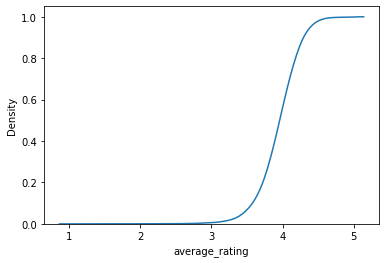

In [16]:
# график функции распределения
# cumulative distribution function
sns.kdeplot(data=db, x='average_rating', cumulative=True)

Сейчас я разберу, что такое функция распределения, что имеет важное значение для понимания видов распределения и их смысла. Все начинается с функции распределения. Вот формальное определение: "Функцией распределения называют функцию F(x), определяющую вероятность того, что случайная величина X в результате испытания примет значение, меньшее x" (Гмурман, ст. 111).

А вот геометрический образ функции распределения: "F(x) есть вероятность того, что случайная величина примет значение, которое изображается на числовой оси точкой, лежащей левее точки x" (Гмурман). 

Выше показан график функции распределения. Как его правильно читать? Проведу из произвольной точки на оси x перпендикуляр. Точка пересечения перпендикуляра с графиком даст значение y - вероятность того, что моя произвольная точка примет значение равное или меньшее x. Например, беру оценку 4. Вижу, что вероятность получить такую оценку между 0,5 и 0,6, примерно 55%.

Раз у меня есть непрерывный график функции, я могу посчитать производные. Поэтому случайную величину можно представить и через т. н. плотность распределения (плотность вероятности). "Плотностью распределения вероятностей непрерывной случайной величины X называют функцию f(x) - первую производную от функции распределения F(x): f(x) = F'(x)" (Гмурман, стр. 116). 

Пример такой функции ниже.

<AxesSubplot:xlabel='average_rating', ylabel='Density'>

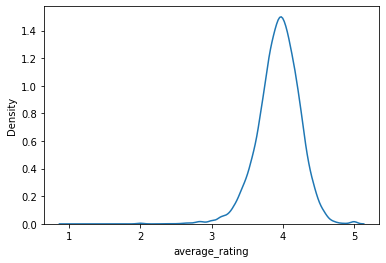

In [17]:
sns.kdeplot(data=db, x='average_rating')

Законами распределения называют различные виды плотности распределения. Например, это может быть равномерное, нормальное, показательное распределение. Чаще всего используется нормальное распределение. 

Про графики PDF, СDF, PPF подробнее здесь [1.3.6.2. Related Distributions](https://www.itl.nist.gov/div898/handbook/eda/section3/eda362.htm)

Text(0.5, 1.0, 'Распределение средних оценок')

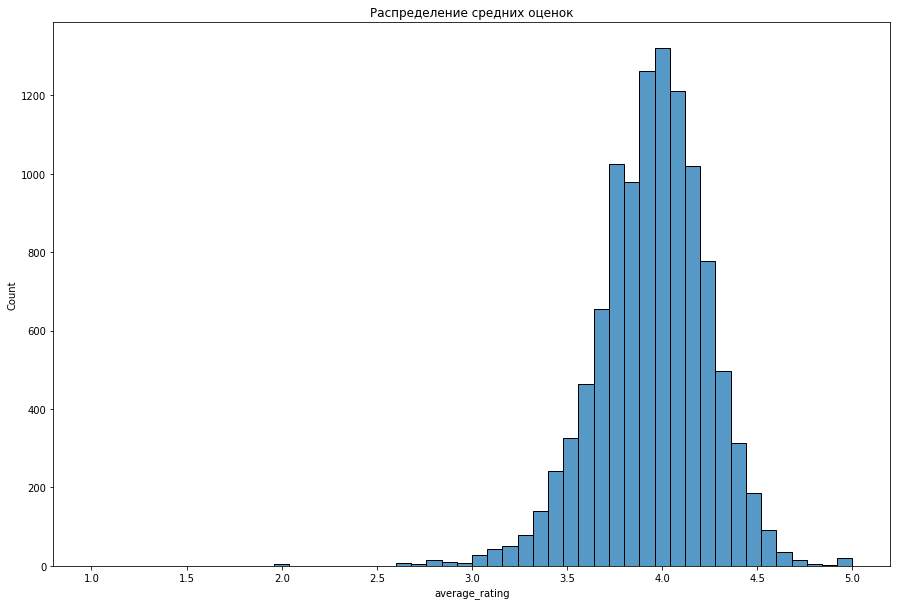

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(db['average_rating'], bins=50) 
plt.title('Распределение средних оценок')

Гистограмма позволяет сделать предположение о виде распределения данных. Знать вид распределения данных необходимо по нескольким причинам. Во-первых, это позволяет делать предсказания о вероятности того или иного события. Во-вторых, для проведения статистических тестов, определения некоторых метрик требуется распределение определенного вида. Как правило, распределение должно быть нормальным. Если распределение нормальным не является, то данные можно привести к нормальному распределению или можно использовать специальные тесты, метрики. Поэтому важно ответить на вопрос: распределены ли данные нормально? Если нет, то нужно установить вид распределения.

Гистограмма показывает, что средние оценки распределены практически нормально. Интересно, что в интервалах 2.5 - 3.0 и 4.8 - 5.0 видны небольшие подъемы линии. При нормальном распределении этого быть не должно. Это означает, что оценки в указанных интервалах имеют вероятность большую, чем это предсказывает нормальное распределение. Дополнительная проверка на нормальность распределения с помощью статистических методов будет показана ниже. 

Гистограмму можно построить разными способами. В случае выше ширина столбика показывает частичный интервал, а высота - количество значений в этом интервале. Возможно построить гистограмму, где высота столбика будет показывать плотность. Подробнее см. в [официальной документации функции](https://seaborn.pydata.org/generated/seaborn.histplot.html).

Про интерпретацию гистограммы можно также прочитать в [учебнике для инженеров](https://www.itl.nist.gov/div898/handbook/eda/section3/histogra.htm). Там же можно обнаружить различные типы гистограмм (как нормальную, так и, например, бимодальную), а также дополнительные статистические методы для определения типа распределения в зависимости от типа гистограммы. Гистограмма показывает:

1. центральную характеристику данных;
2. масштаб данных;
3. скошенность;
4. наличие выбросов;
5. наличие нескольких мод в данных. 

Трансформация данных к нормальному распределению объясняется в [6.5.2. What to do when data are non-normal](https://www.itl.nist.gov/div898/handbook/pmc/section5/pmc52.htm)

# Выбросы

В учебнике для инженеров дано следующее определение выбросов: "Выбросы - это точки данных, которые получены не из того же распределения, из которого получена основная масса данных". 

То есть выброс - это такое значение, которое пришло не из того распределения, из которого пришли основные данные. В этом смысл того, чтобы определить распределение для большинства данных, а затем уже выброс. Редкие данные возможны и в границах распределения для основных данных, но вот выброс выходит вообще за границы распределения, то есть например за пределы колокола в нормальном распределении. В этом смысл того, что сначала надо найти отличающиеся от других данные, а затем проверить их на влиятельность. 

Вот рекомендации по обработке выбросов из учебника для инженеров:

1. К каждому выбросу необходимо относится серьезно. Не рекомендуется автоматически удалять выбросы. Наличие выбросов может быть не просто ошибкой в данных, выбросы могут сообщать важную информацию о данных. Поэтому надо постараться объяснить, чем вызваны выбросы в данных.

2. Если гистограмма показывает наличие выбросов, то рекомендуется следующее:
1) применить ящик с усами, который лучше гистограммы показывает наличие и количество выбросов;
2) применить Grubbs' Test или иные тесты для обнаружения выбросов.

Рекомендуемые тесты на выбросы:

1) Grubbs' Test - если тест на единичный выброс;
2)  Tietjen-Moore Test - в случае, если в данных предполагается более одного выброса. Необходимо заранее знать точное количество выбросов.
3) Generalized Extreme Studentized Deviate (ESD) Test - также, если в данных более одного выброса. Необходимо знать только верхнюю границу ожидаемого числа выбросов. Рекомендуется, когда точное количество выбросов неизвестно. 

Как правило, при обнаружении выбросов исходят из того, что данные распределены нормально. Если это не так, то можно привести данные к нормальному распределени.

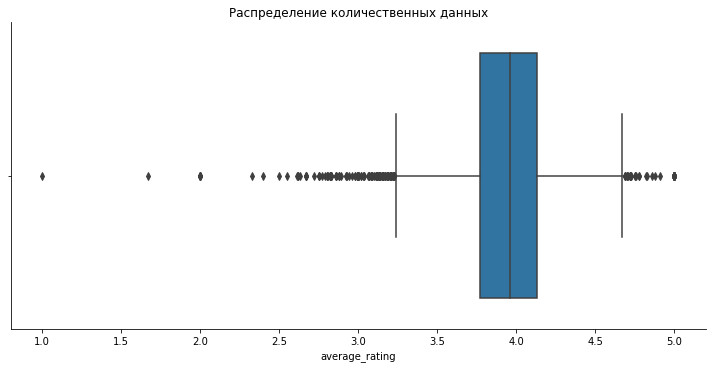

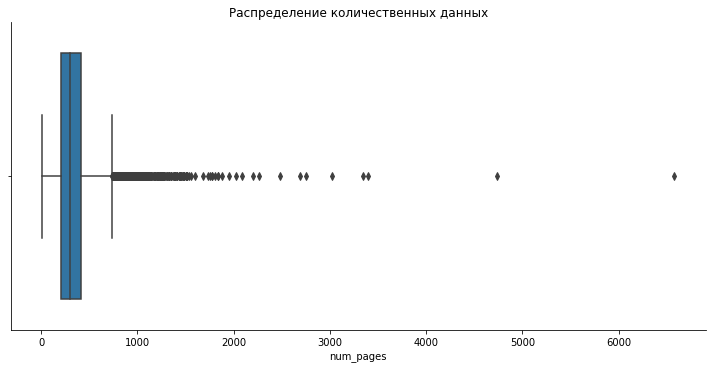

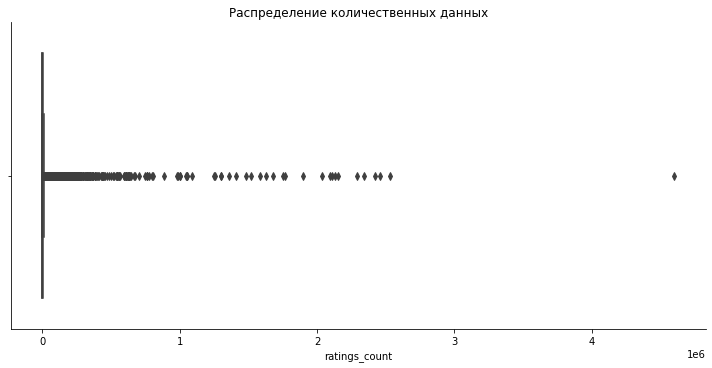

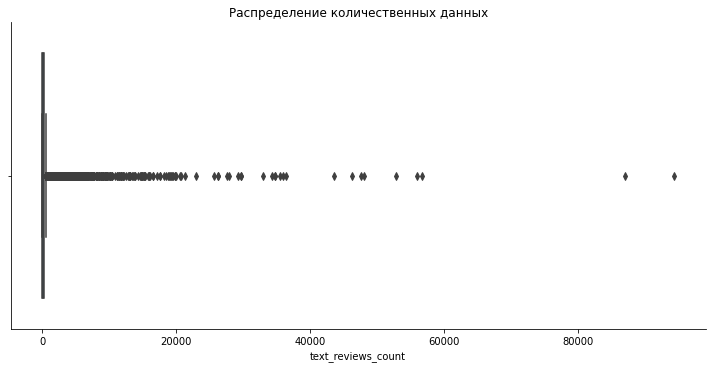

In [19]:
# стандартная проверка на выбросы
for i in ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']:
    sns.catplot(kind='box', data=db, aspect=2, x=i)
    plt.title('Распределение количественных данных')

Это - ящики с усами. Их придумал отец-основатель анализа данных Тьюки. В прямоугольнике - по середине - показана медиана. Левый край прямоугольника - это 25%-квартиль, правый край - 75%. Усы - это межквартильный размах. За пределами усов - выбросы. 

Интересный вопрос про ящик - это почему он то сжимается, то растягивается. Почему медиана скачет от левой стороны к правой? Ведь это медиана, она должна быть посередине, нет? Все верно, почти. Разберу это на примере. 

*Важное терминологическое замечание*. "Квантиль 0,5 называют медианой. Для а = 0,25, 0,5 и 0,75 соответствующие квантили называются квартилями, а = 0,2, 0,4, 0,6, 0,8 они называются квинтилями".

{'whiskers': [<matplotlib.lines.Line2D at 0x2c55761cfa0>,
 'caps': [<matplotlib.lines.Line2D at 0x2c557762700>,
 'boxes': [<matplotlib.lines.Line2D at 0x2c55761cc10>],
 'medians': [<matplotlib.lines.Line2D at 0x2c557762e20>],
 'fliers': [<matplotlib.lines.Line2D at 0x2c5577701f0>],
 'means': []}

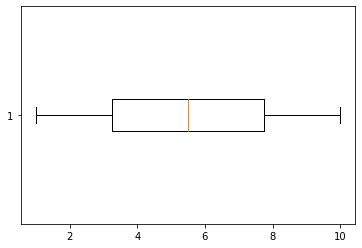

In [20]:
# создаю вектор данных
example = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) 

# и строю боксплот
plt.boxplot(example, vert=False)

In [21]:
# найду медиану
np.median(example)

5.5

{'whiskers': [<matplotlib.lines.Line2D at 0x2c557d572e0>,
 'caps': [<matplotlib.lines.Line2D at 0x2c557d57a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x2c557d4af70>],
 'medians': [<matplotlib.lines.Line2D at 0x2c557d64160>],
 'fliers': [<matplotlib.lines.Line2D at 0x2c557d644f0>],
 'means': []}

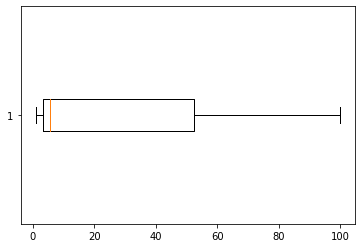

In [22]:
# создадю еще один вектор данных
example1 = np.array([1, 2, 3, 4, 5, 6, 51, 53, 54, 100]) 

# и опять строю боксплот
plt.boxplot(example1, vert=False)

In [23]:
# найду медиану на новых данных
np.median(example1)

5.5

In [24]:
# ниже подробно разберу, как образуются усы, 
# а заодно и как писать функции
q1, q3 = np.percentile(example1, [25, 75])

# q1 левый (нижний) квартиль, q3 правый (верхний) квартиль
iqr = q3 - q1 
iqr

49.25

In [25]:
# левый (нижний) ус
lower_bound = q1 - (iqr*1.5) 
lower_bound

-70.625

In [26]:
# правый (верхний) ус
upper_bound = q3 + (iqr*1.5) 
upper_bound

126.375

Что здесь произошло? Я создал второй вектор, где заменил 7, 8, 9, 10 на  51, 53, 54, 100. Количество значений не изменилось. Не изменилась и сама медиана - она осталась 5.5. Однако линия медианы "прижалась" к левой стороне ящика. Почему? 

На оси **x** откладываются значения вектора. Ось **y** показывает количество таких значений. В первом случае на оси **x** отложены значения от 1 до 10. Во втором случае отложены значения от 1 до 100. Количество значений ниже и выше медианы не изменилось, но изменился масштаб. 

Усы же строятся несколько иначе. Определяю границы усов (lower bound, upper bound). Смотрю, а какие из имеющихся значений не выходят за границы усов. До минимального (максимального) значения наших усов в установленных границах строю усы. Например, граница для верхнего уса 126, но фактически есть только значение 100. Строим ус до 100. Но граница нижнего уса - 71, однако минимальное фактическое значение это 1, поэтому строим ус до 1. Поэтому и возникает разница в длине усов. 

**Совет**. Если я столкнулся с трудностью в понимании какой-либо формулы, статистики и т.п., то всегда начинаю с простого случая.

In [27]:
# применю указанный подход к реальным данным
q1, q3 = np.percentile(db['average_rating'], [25, 75]) 

# межквартильный размах
iqr = q3 - q1 

# из нижней границы вычитаю полтора межквартильных размаха
lower_bound = q1 - (iqr*1.5) 

# к верхней границе прибавляю полтора межквартильных размаха
upper_bound = q3 + (iqr*1.5) 
print(lower_bound, upper_bound)

3.2300000000000004 4.67


Итак, усы показывают число 3.23. Ниже этого числа - выбросы.

In [28]:
"""
Function to detect outliers in data.
"""

def outliers(x): 
    q1, q3 = np.percentile(x, [25, 75])  # заменил db['average_rating'] на переменную
    iqr = q3 - q1
    lower_bound = q1 - (iqr*1.5)
    upper_bound = q3 + (iqr*1.5)
    return lower_bound, upper_bound  # результат, который возвращает функция

In [29]:
# пример на использование генератора
data = [{'Нижний выброс': outliers(i)[0], 
    'Верхний выброс': outliers(i)[1]} for i in [db['average_rating'], db['num_pages'], db['ratings_count'], db['text_reviews_count']]]

In [30]:
# способ создания датафрейма из словаря
pd.DataFrame(data, index=['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count'])

,Нижний выброс,Верхний выброс
average_rating,3.230,4.670
num_pages,-118.000,738.000
ratings_count,-7547.625,12891.375
text_reviews_count,-347.000,605.000


In [31]:
"""

# приводится для примера

# построю график парных распределений 
# для количественных признаков

sns.pairplot(db) # может долго вычислять

"""

'\n\n# приводится для примера\n\n# построю график парных распределений \n# для количественных признаков\n\nsns.pairplot(db) # может долго вычислять\n\n'

# Визуализация категориальных данных

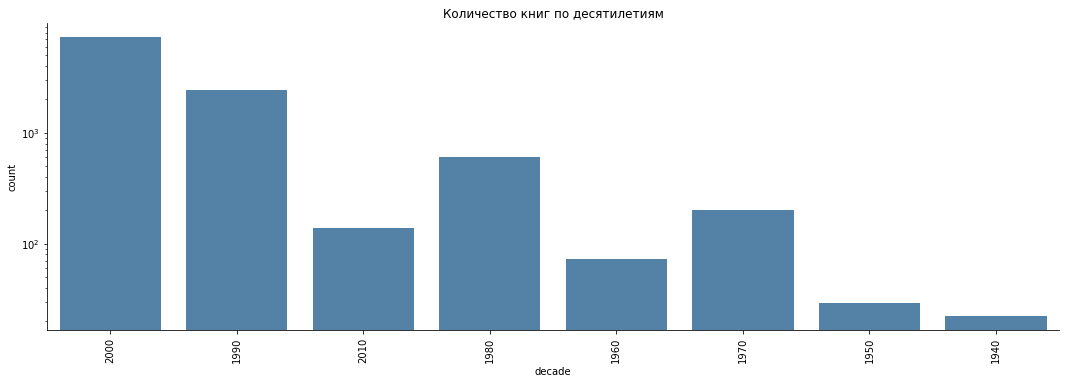

In [32]:
# распределение книг по десятилетиям
sns.catplot(x='decade', data=db, color='steelblue', aspect=3, kind='count')

# поворачиваю подписи по оси X
plt.xticks(rotation=90) 

# использую логарифмическую шкалу
plt.yscale('log') 
plt.title('Количество книг по десятилетиям')
plt.show()

Text(0.5, 1.0, 'Распределение книг по кварталам')

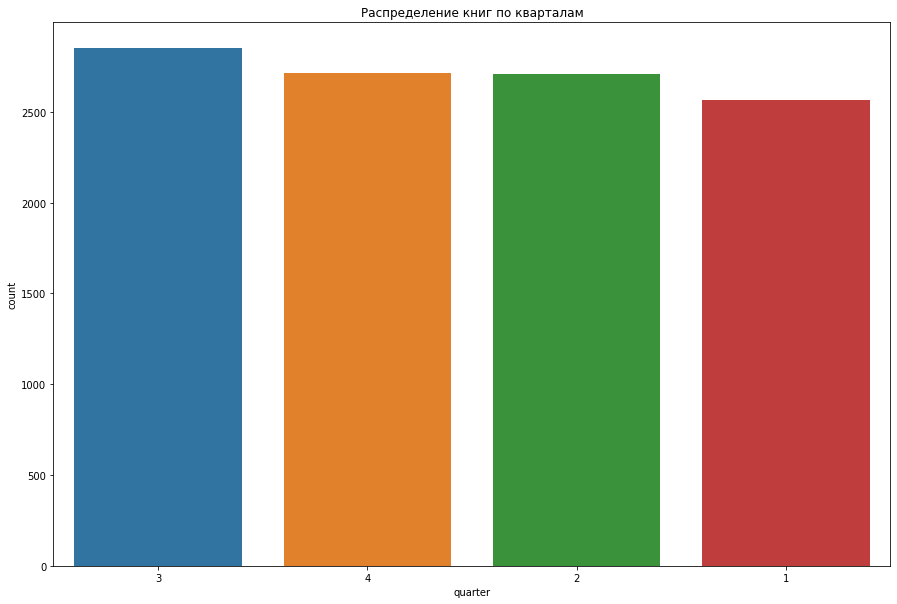

In [33]:
# распределение по кварталам
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(x=db['quarter']) 
plt.title('Распределение книг по кварталам')

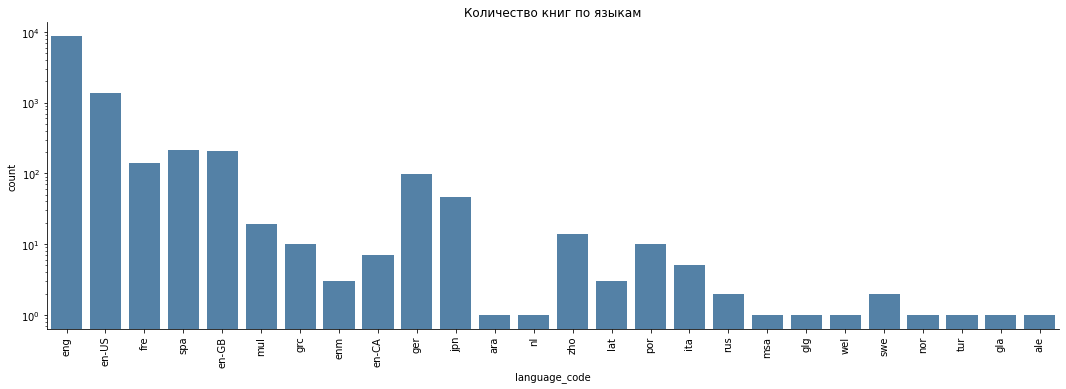

In [34]:
# распределение книг по языкам
sns.catplot(x='language_code', data=db, color='steelblue', aspect=3, kind='count')

# поворачиваю подписи по оси X
plt.xticks(rotation=90) 

# использую логарифмическую шкалу
plt.yscale('log') 
plt.title('Количество книг по языкам')
plt.show()

Text(0.5, 1.0, 'Средние оценки по декадам')

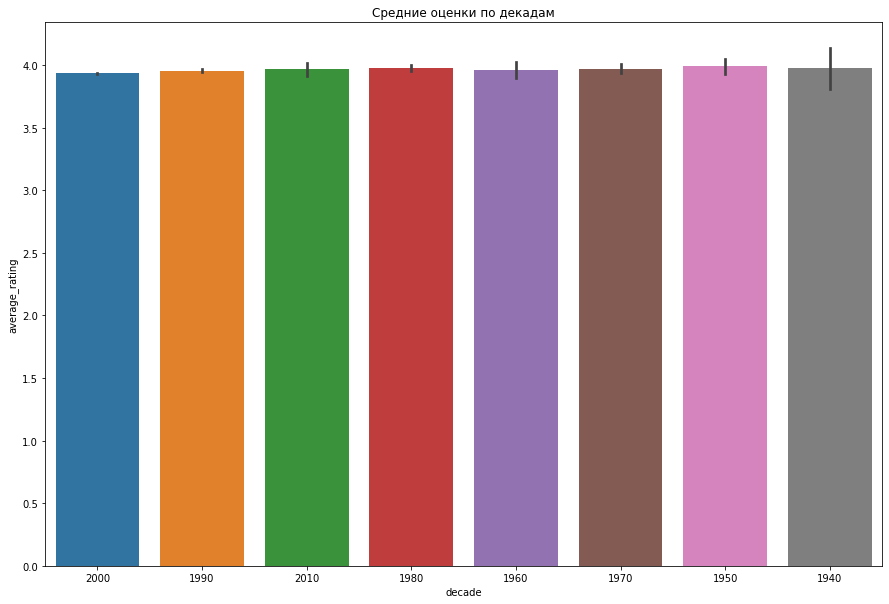

In [35]:
# распределение средних оценок по декаде издания книги, 
# сo стандартными отклонениями
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=db['decade'], y=db['average_rating']) 
plt.title('Средние оценки по декадам')

Text(0.5, 1.0, 'Средние оценки по кварталу')

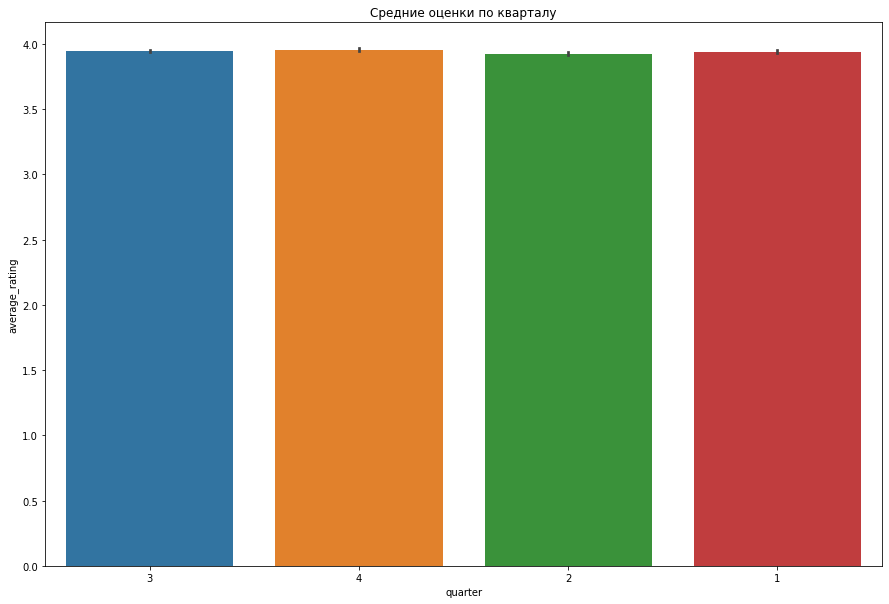

In [36]:
# распределение средних оценок по кварталу издания книги, 
# сo стандартными отклонениями
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=db['quarter'], y=db['average_rating']) 
plt.title('Средние оценки по кварталу')

Text(0.5, 1.0, 'Средние оценки по языкам')

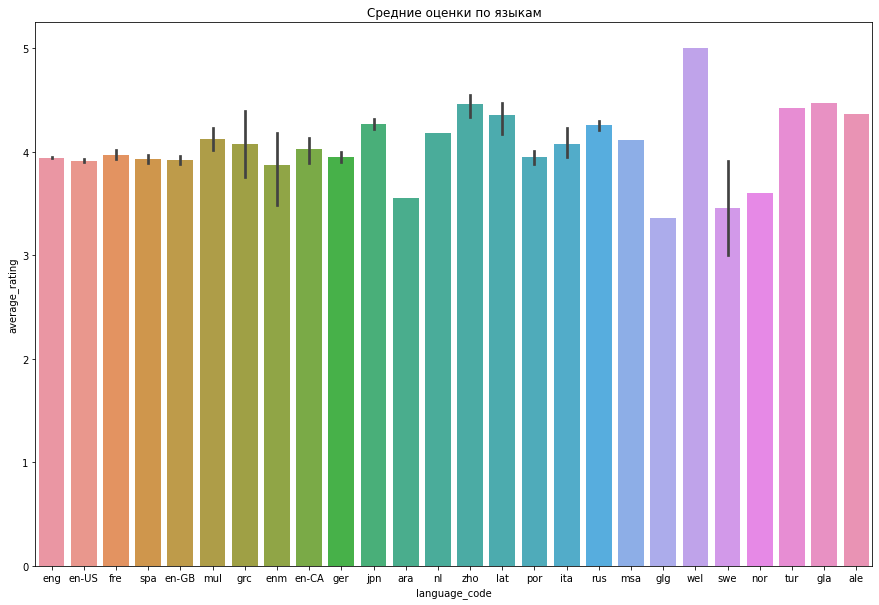

In [37]:
# распределение средних оценок по языкам издания книги, 
# сo стандартными отклонениями
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=db['language_code'], y=db['average_rating']) 
plt.title('Средние оценки по языкам')

Text(0.5, 1.0, 'Средние оценки по многотомности')

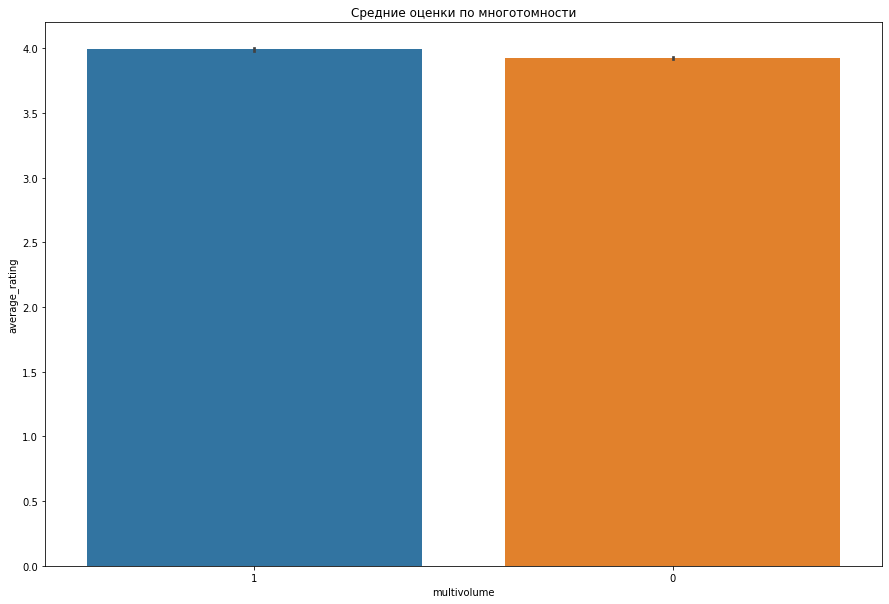

In [38]:
# распределение средних оценок по признаку многотомности, 
# сo стандартными отклонениями
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=db['multivolume'], y=db['average_rating']) 
plt.title('Средние оценки по многотомности')

В последних графиках я использовал стандартное отклонение. Многие авторы рекомендуют всегда, когда это возможно, выводить графики именно с указанием стандартного отклонения. В самом деле, в рамках статистики простое указание на среднее значение недостаточно полно описывает данные, необходимо еще указать, как минимум, отклонение от среднего. 

# Проверка статистических гипотез

Проверка статистических гипотез является важной задачей математической статистики. Вот цитата из Гмурмана, которая должна это показать.

"Статистической называют гипотезу о виде неизвестного распределения или о параметрах известных распределений.
Например, статистическими являются гипотезы:
1) генеральная совокупность распределена по закону Пуассона;
2) дисперсии двух нормальных совокупностей равны между собой.
В первой гипотезе сделано предположение о виде неизвестного распределения, во второй - о параметрах двух известных распределений"(Гмурман, стр. 281).

Гипотезы делят на нулевую (основную) и конкурирующую (альтернативную). Если можно принять нулевую гипотезу, то необходимо отвергнуть альтернативную. Если же принять нулевую гипотезу нельзя, то необходимо принять альтернтативную. Пример: если нулевая гипотеза утверждает, что математическое ожидание равно 10, то альтернативная гипотеза будет утверждать, что математическое значение не равно 10.

Нулевая гипотеза может быть либо истинной, либо ложной. Независимо от этого, можно угадать истинность или угадать ложность гипотезы, или не угадать ни того, ни другого. С учетом этого, возможные ошибки делят на два вида:
1) ошибка первого рода возникает, если отвергнута истинная гипотеза. Например, если гипотеза, что математическое ожидание равно 10 является истинной, но пришлось ее отвергнуть, то возникает ошибка первого рода;
2) ошибка второго рода возникает, если принята неправильная гипотеза. Например, если гипотеза, что математическое ожидание равно 10 является ложной, но пришлось ее принять, то возникает ошибка второго рода. 

"Вероятность совершить ошибку первого рода принято обозначать через a; ее называют уровнем значимости. Наиболее часто уровень значимости принимают равным 0,05 или 0,01. Если, например, принят уровень значимости, равный 0,05, то это означает, что в пяти случаях из ста имеется риск допустить ошибку первого рода (отвергнуть правильную гипотезу)" (Гмурман, стр. 283).

Итак, есть нулевая гипотеза. Возникает вопрос, а как ее проверить? То есть как узнать, что это гипотеза истинная, или узнать, что гипотеза ложная?

Чтобы проверить нулевую гипотезу, нужно выплонить несколько шагов:

1) подобрать специальную случайную величину, распределение которой точно или примерно известно. Эта величина может быть обозначена как U или Z при нормальном распределении, F - при распределении по Фишеру-Снедекора и т.п. Эту величину называют статистическим критерием;
2) на основании имеющихся данных рассчитать те значения, которые входят в специальную случайную величину. Так получают частное (наблюдаемое) значение критерия.

Вот это на примере. Предположим, что специальная случайная величина это F = s1**2 / s2**2 (Гмурман, стр. 283). Тогда можно посчитать на наборе данных показатели s1 и s2, а значит расчитать F. Что дальше?

"После выбора определенного критерия множество всех его возможных значений разбиваются на два непересекающихся подмножества: одно из них содержит значения критерия, при которых нулевая гипотеза отвергается, а другая - при которых она принимается.

Критической областью называют совокупность значений критерия, при которых нулевую гипотезу отвергают. 

Областью принятия гипотезы (областью допустимых значений) называют совокупность значений критерия, при которых гипотезу принимают. 

Основной принцип проверки статистических гипотез можно сформулировать так: если наблюдаемое значение критерия принадлежит критической области - гипотезу отвергают; если наблюдаемое значение критерия принадлежит области принятия гипотезы - гипотезу принимают. 

Поскольку критерий K - одномерная случайная величина, все ее возможные значения принадлежать некоторому интервалу. Поэтому критическая область и область принятия гипотезы также являются интервалами и, следовательно, существуют точки, которые их разделяют. 

Критическими точками (границами) k(кр) называют точки, оотделяющие критическую область от области принятия гипотезы.

Различают одностороннюю (правостороннюю или левостороннюю) и двусторонюю критические области. 

Правосторонней называют критическую область, определяемую неравенством K > k(кр), где k(кр) - положительное число.

Левосторонней называют критическую область, определяемую неравенством K < k(кр), где k(кр) - отрицательное число.

![Критические точки](./images/krit.png 'Критические точки')

Односторонней называют правостороннюю или левостороннюю критическую область.

Двусторонней называют критическую область, определяемую неравенствами K < k(кр)1, K > k(кр)2, где k(кр)2 > k(кр)1" (Гмурман, ст. 284)

Как найт критическую точку? Для этого выбирают небольшой уровень значимости a. "Затем ищут критическую точку, исходя из требования, чтобы при условии справедливости нулевой гипотезы вероятность того, что критерий К примет значения, большее k(кр) была равна принятому уровню значимости:

P(K > k(кр)) = а".

Это значение P также называют p-value.

Важно также помнить, что проверка статистических гипотез не доказывает гипотезы. Одного доказательства еще не достаточно для принятия гипотезы. Однако достаточно одного противоречащего гипотезе факта, чтобы ее отвергнуть. Поэтому проверяют гипотезу на возможность принятия несколькими способами, а для отрицания гипотезы хватит и одного. 

Еще одна важная концепция - это мощность критерия. "Мощностью критерия называют вероятность попадания критерия в критическую область при условии, что справедлива конкурирующая гипотеза. Другими словами, мощность критерия есть вероятность того, что нулевая гипотеза будет отвергнута, если верна конкурирующая гипотеза" (Гмурман, стр. 287). В гл. 19 Гмурмана можно найти много примеров на расчет статистик и проверку гипотез.

Вот пример того же самого, но на основе t-testa. Для такой статистики как t-критерий нулевая гипотеза - это равенство средних значений двух выборок. Альтернативная гипотеза: средние двух выборок не равны. P-value это вероятность получить равенство средних значений на тех выборках, что у нас есть. Если такая вероятность меньше заданного уровня (как правило, 0.05), то надо отвергнуть нулевую гипотезу. Другими словами, если p-value < 0.05, то вероятность получить равенство двух средних значений очень низкая. Вероятность представляется значениями от 0 до 1, где 0 - это невозможное событие, 1 - это событие, которое безусловно произойдет. Из этого видно, что 0.05 это очень близкое значение к 0, то есть невозможности. Поэтому надо отбросить нулевую гипотезу и принять альтернативную: средние двух выборок не равны.

Дополнительно надо учитывать, что тесты могут быть параметрическими и непараметрическими. Параметрические тесты основаны на известных свойствах распределений. Непараметрические не учитывают свойства распределений. В случае непараметрических тестов метрики распределения определяются с помощью многократного повторения теста.

Также все тесты можно разделить на: применимые только к количественным признакам, применимые только к категориальным признакам, применимые как к количественным, так и категориальным признакам. 

Еще одно деление: одни тесты говорят только о наличии связи (отсутствии связи) между признаками, другие тесты также показывают силу этой связи.

Дополнительно про статистические тесты см. [главу 7.1.Introduction](https://www.itl.nist.gov/div898/handbook/prc/section1/prc1.htm).

# Проверка на нормальное распределение

Базовая проверка на нормальное распределение может быть проведена с помощью критериев ассиметрии и эксцесса. Выше я уже дал теоретическое описание данных критериев. 

Теперь практические правила интерпретации.

1. "Если "длинная часть" кривой расположена правее моды (точки максимума дифференциальной функции), то ассиметрия положительная, если слева - отрицательна" (Гмурман, стр. 138).
2. "Если эксцесс некоторого распределения отличен от нуля, то кривая этого распределения отличается от нормальной кривой: если эксцесс положительный, то кривая имеет более высокую и "острую" вершину, чем нормальная кривая; если эксцесс отрицательный, то сравниваемая кривая имеет более низкую и "плоскую" вершина. чем нормальная кривая" (там же).
3. Если skew положителен, то данные скошены вправо, а если отрицателен то влево. Если kurtosis (эксцесс) положителен, то распределение имеет острую вершину, если отрицатеьный то распределение имеет пологую вершину. Нормальное распределение имеет скошенность 0 и вершину около 4. Эксцесс - это статистическая мера, которая определяет, насколько сильно хвосты распределения отличаются от хвостов нормального распределения. Другими словами, эксцесс определяет, содержат ли хвосты данного распределения экстремальные значения.

In [39]:
# ассиметрия
db['average_rating'].skew()

-0.6775337593336154

In [40]:
# эксцесс
db['average_rating'].kurtosis()

3.191426082449858

C:\Users\runaz\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


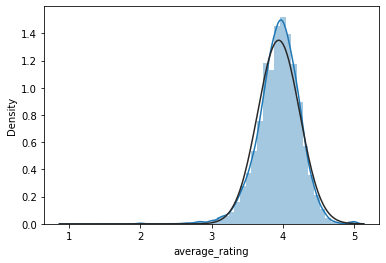

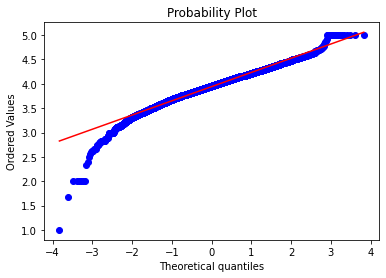

In [41]:
# пример визуального определения нормального распределения
sns.distplot(db['average_rating'], fit=norm)
fig = plt.figure()
res = stats.probplot(db['average_rating'], plot=plt)

Здесь я использую Normal Probability Plot. Подробнее про этот график можно прочитать [здесь](https://www.itl.nist.gov/div898/handbook/eda/section3/normprpl.htm). Хорошее объяснение и пример построения графика можно найти также [здесь](https://www.storyofmathematics.com/normal-probability-plot).

Вот как выглядит график в общем виде:

![Normal Probability Plot](./images/npp.png 'Normal Probability Plot')

По вертикали графика откладываем упорядоченные данные. По горизонтали откладываем Normal order statistic medians. Как считается вот этот Normal order statistic medians? Это можно обнаружить по указанной ссылке. 

Normal Probability Plot отвечает на два вопроса:

1) данные распределены нормально?
2) какой природы распределение? есть скос? хвост длинный или короткий?

Как и для большинства иных тестов, для этого графика важно соблюдение требования о случайности данных.

Здесь можно применить технику приближенного понимания. То, о чем говорит график Normal Probability Plot, это по существу наложение гистограммы по имеющимся данным на гистограмму, о которой известно, что она соответствует нормальному распределению. 

Теперь про интерпретацию. Главная интерпретация в том, что график должен быть линейным, чтобы можно было говорить о том, что применимо нормальное распределение. Важно, что линия строится между точкой первого и третьего квартиля. Про отклонения от прямой читайте [здесь и ниже](https://www.itl.nist.gov/div898/handbook/eda/section3/eda33l2.htm).

Для определения типа распределения можно использовать Tukey Lambda PPCC. На Python его можно найти [здесь](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ppcc_plot.html). В этом случае распределение определяется по значению лямбды. Еще здесь [1.3.6.6.15. Tukey-Lambda Distribution](https://www.itl.nist.gov/div898/handbook/eda/section3/eda366f.htm).

График Quantile-Quantile Plot отвечает на вопрос "происходят ли два набора данных из одного распределения". В этом смысле график Normal Probability Plot есть только частный случай графика Quantile-Quantile Plot. Подробнее про этот последний [здесь](https://www.itl.nist.gov/div898/handbook/eda/section3/qqplot.htm), а также здесь [pg.qqplot](https://pingouin-stats.org/generated/pingouin.qqplot.html#pingouin.qqplot)

Ниже я применю тест Шапиро. См. подробнее [здесь](https://pingouin-stats.org/generated/pingouin.normality.html?highlight=shapiro)

In [42]:
# тест Шапиро
stats.shapiro(db['average_rating'])

C:\Users\runaz\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9734746217727661, pvalue=1.3771961307384302e-40)

На этом примере еще раз разберу, что же означает применение статанализа. Я вычисляю интересующую меня статистику (в данном случае - Шапиро) и проверяю нулевую гипотезу. Например, здесь нулевая гипотеза: данные распределены нормально. Так как p-value < 0.05 (так как вывод имеет экспоненциональную форму "e-40"), я должен отвергнуть нулевую гипотезу и принять альтернативную, то есть отвергаю гипотезу, что данные распределены нормально, и принимаю гипотезу, что данные не распределены нормально. Такой результат называется статистически значимым. Возможно применение и иных методов: тест на нормальность D'Agostino-Pearson, тест Колмагорова-Смирнова.

Итак, данные не распределены нормально. В это случае можно применить непараметрические тесты, например корреляцию Спирмена или перестановочный тест (пермутацию).

**Совет** 

Если предположения о нормальности или однородности дисперсий не выполняются, то можно преобразовать данные таким образом, чтобы они соответствовали нормальным. В этом случае важно помнить, что интерпретация результатов теста требует выполнения обратных преобразований данных. Некоторые преобразования данных по-разному влияют на нормальность и дисперсию, поэтому следует проверять различные преобразования. Есть, конечно, общие преобразования, которые используются. О них я расскажу ниже.

# Корреляция

Стандартный тест для количественных признаков - это проверка корреляции Пирсона. Однако предварительно надо проверить условия для этого теста. Если условия соблюдаются, то можно применять тест. Если условия не соблюдаются, то можно либо подогнать данные к нормальному распределению, либо использовать непараметрические тесты. Это правило применяется к любому тесту: всегда надо сначала проверить соблюдение условий для применения конкретного теста.


*Когда применяется?*

Корреляция по Пирсону применяется, когда нужно проверить связь между двумя непрерывными переменными.

*Условия применения теста*

1) независимость выборок, 
2) нормальное распределение. 

*Альтернативы, если условия не выполняются*
 
Непараметрические тесты, корреляция Спирмена, пермутация

*Формула*

См. подробнее [здесь](https://www.pythonfordatascience.org/variance-covariance-correlation/)

*Интерпретация*
 
Если значение больше 0 и меньше 1, то положительная корреляция (уменьшение-уменьшение (минус на минус дает плюс), увеличение-увеличение (плюс на плюс дает плюс)), при 0 связи нет, если меньше 0, то отрицательная (уменьшение-увелиение (минус на плюс дает минус), увеличение-уменьшение (плюс на минус дает минус)). 
 
*Особенности*

Важно, если связь носит нелинейный характер, то возможна ошибочная интерпретация. Чувствителен к выбросам, можно применять робастную корреляцию Пирсона.
Если есть подозрение, что третья переменная влияет на две, у которых смотрим корреляцию, то можно применить частичную корреляцию.
Можно использовать Distance correlation для определения не только линейной, но и нелинейной связи переменных.
Сильно коррелированные переменные можно объединить в одну, например через умножение, деление. Удалять изначальные нельзя. Можно также использовать метод главных компонент. При подозрении на нелинейность связи возможно применение регуляризации, например Lasso или Ridge.
 
Независимость выборок понятие оценочное, поэтому определяется исследователем. Нормальное распределение можно проверить специальными методами: визуально, тестами.

In [43]:
# корреляция один против всех по Спирмену
pg.pairwise_corr(db, columns=[['average_rating'], ['num_pages', 'ratings_count', 'text_reviews_count']], method='spearman', padjust='bonf') 

,X,Y,method,alternative,n,r,CI95%,p-unc,p-corr,p-adjust,power
0,average_rating,num_pages,spearman,two-sided,10838,0.119,"[0.1, 0.14]",0.000,0.000,bonf,1.000
1,average_rating,ratings_count,spearman,two-sided,10838,0.086,"[0.07, 0.1]",0.000,0.000,bonf,1.000
2,average_rating,text_reviews_count,spearman,two-sided,10838,0.030,"[0.01, 0.05]",0.002,0.005,bonf,0.887


Получилась таблица корреляции "один против всех", когда один признак **average_rating** проверяется на корреляцию со всеми остальными. Разберу, что означает каждый показатель.
* **n** это количество наблюдений (строк), которые учитывались при построении корреляции;
* **r** это коэффициент корреляции по Спирмену. Хорошее объяснение можно найти в книге Статистика для всех Сары Бослаф. Видно, что корреляция слабая. Возможно только, что количество страниц связано положительной корреляцией с оценкой, то есть уменьшение количества страниц ведет к уменьшению оценки, увеличение - к увеличению;
* **CI95%** это доверительный интервал для r. Важно помнить, что во всех случаях, когда это позволяют статистические тесты, результаты таких тестов необходимо приводить с доверительными интервалами;
* **r2** это коэффициент детерминации, то есть какая доля дисперсии average_rating может быть объяснена другим признаком;
* **z** это стандартизированная оценка корреляции;
* **p-unc** это не скорректированная оценка p-value;
* **p-corr** это скорректированная оценка p-value;
* **p-adjust*** это поправка, которую применили к p-value. В данном случае Бонферрони;
* **power** это мощность, то есть 1 минус вероятность допустить ошибку 2 типа. Другими словами, вероятность обнаружения существующей закономерности.

*Выводы*

Получил корреляцию между **average_rating** и числовыми признаками. Вывод следующий: средняя оценка не имеет значимых связей с другими количественными данными. Кажется, что не достигнуто никакого результата? Это не так. Во-первых, отсутствие сильной корреляции пригодится при машинном обучении. Во-вторых, установлено, например, что от количества страниц в книге оценка не зависит. В тоже время зависимость от количества страниц все же выше, чем от количества оценок или количества обзоров. Другими словами, желание читателей оставить отзыв не коррелирует с оценкой.

Остается вопрос, а как быть с категориальными признакми? Здесь понадобится дисперсионный анализ. Но сначала визуализирую корреляцию.

<AxesSubplot:>

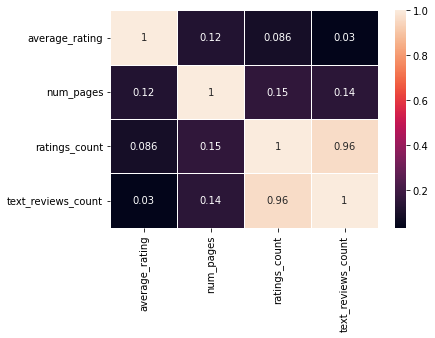

In [44]:
# визуализация корреляции
sns.heatmap(db.corr(method='spearman'), annot=True, linewidths=1)

# Дисперсионный анализ

Здесь я дам сначала описание дисперсионного анализа по Гмурману (стр. 349 и далее).

"На практике дисперсионный анализ применяют, чтобы установить, оказывает ли существенное влияние некоторый качественный фактор F, который имеет p уровней F1, F2, F3... Fp, на изучаемую величину X. Например, если требуется выяснить, какой вид удобрений наиболее эффективен для получения наибольшего урожая, то фактор F - удобрение, а его уровни - виды удобрений.  

Основная идея дисперсионного анализа состоит в сравнении "факторной дисперсии", порождаемой воздействием фактора, и "остаточной дисперсии", обусловленной случайными причинами. Если различие между этими дисперсиями значимо, то фактор оказывает существенное влияние на X: в этом случае средние наблюдаемых значений на каждом уровне (групповые среднии) различаются также значимо. 

Если уже установлено, что фактор существенно влияет на X, а требуется выяснить, какой из уровней оказывает наибольшее воздействие, то дополнительно производят попарное сравнение средних.

Иногда дисперсионный анализ применяется, чтобы установить однородность нескольких совокупностей (дисперсии этих совокупностей одинаковы по предположению; если дисперсионный анализ покажет, что и математические ожидания одинаковы, то в этом смысле совокупности однородны). Однородные же совокупности можно объединить в одну и тем самым получить о ней более полную информацию, следовательно, и более надежные выводы.

В более сложных случаях исследуют воздействие нескольких факторов на нескольких постоянных или случайных уровнях и выясняют влияние отдельных уровней и их комбинаций (многофакторный анализ)".

Теперь как это считается.

Итак, вот какие предположения: 
1. есть количественный нормально распределенный признак X;
2. на этот признак воздействует фактор F;
3. фактор F имеет p постоянных уровней;
4. число наблюдений (испытаний) на каждом уровне одинаково и равно q (это не обязательно должно быть так, см. стр. 358 Гмурмана).

Всего наблюдений n=pq значений x(ij) признака X, где i - номер испытания (i = 1, 2,...q), j - номер уровня фактора (j = 1, 2, ...p). Вот как это выглядит в таблице.

![Набор данных](./images/table3.png 'Набор данных')

Теперь введу показатель Sобщ - общая сумма квадратов отклонений наблюдаемых значений от общей средней.

![Общая сумма](./images/sобщ.png 'Общая сумма')

Следующий показатель S(факт) - это факторная сумма квадратов отклонений групповых средних от общей средней, которая характеризует "рассеяние между группами".

![Факторная сумма](./images/sфакт.png 'Факторная сумма')

Еще один показатель S(ост) - остаточная сумма квадратов отклонений наблюдаемых значений группы от своей групповой средней, которая характеризует рассенияние "внутри группы".

![Остаточная сумма](./images/sост.png 'Остаточная сумма')

Остаточную сумму можно определить и проще:

![Остаточная сумма](./images/sост2.png 'Остаточная сумма')

[Понять это можно примерно так как на графике

![График](./images/graf1.png 'График')

Как прочитать этот график? Есть группы, которые разделены красными вертикальными чертами. Для каждой группы определено среднее - зеленая линия. Но есть также общая для всех точек средняя - фиолетовая черта. Для первой группы горизонтальной желтой штриховкой показано, что значит разность между средним и значением. Есть также разность среднего группового и общего среднего.

Хорошее пояснение этих показетелей дано на стр. 352 Гмурмана. Привожу его целиком:

"1. Убедимся, что S(факт) характеризует воздействие фактора F. Допустим, что фактор оказывает существенное влияние на X. Тогда группа наблюдаемых значений признака на одном определенном уровне, вообще говоря, отличается от групп наблюдений на других уровнях. Следовательно, различаются и групповые средние, причем они тем больше рассеяны вокруг общей средней, чем большим окажется воздействие фактора. Отсюда следует, что для оценки воздействия фактора целесообразно составить сумму квадратов отклонений групповых средних от общей средней (отклонение возводят в квадрат, чтобы исключить погашение положительных и отрицательных отклонений). Умножив эту сумму на q, получим S(факт). Итак, S(факт) характеризует воздействие фактора.
2. Убедимся, что S(ост) отражает влияние случайных причин. Казалось бы, наблюдения одной группы не должны различаться. Однако, поскольку на X, кроме фактора F, воздействуют и случайные причины, наблюдения одной и той же группы, вообще говоря, различны и, значит, рассеяны вокруг своей групповой средней. Отсюда следует, что для оценки влияния случайных причин целесообразно составить сумму квадратов отклонений наблюдаемых значений каждой группы от своей групповой средней, то есть S(ост). Итак, S(ост) характеризует воздействие случайных причин. 
3. Убедимся, что S(общ) отражает влияние и фактора, и случайных причин. Будем рассматривать все наблюдения как единую совокупность. Наблюдаемые значения признака различны вследствие воздействия фактора и случайных причин. Для оценки этого воздействия целесообразно составить сумму квадратов отклонений наблюдаемых значений от общей средней, то есть S(общ)"

Вот пример. Предположим, надо проверить при заданном уровне значимости нулевую гипотезу о равенстве нескольких средних нормальных совокупностей с неизвестными, но одинаковыми дисперсиями. "Для того чтобы проверить нулевую гипотезу о равенстве групповых средних нормальных совокупностей с одинаковыми дисперсиями, достаточно проверить по критерию F [отношение квадрата большей дисперсии к квадрату меньшей дисперсии, распределение Фишера-Снедекора] нулевую гипотезу о равенстве факторной и остаточной дисперсий. В этом и состоит метод дисперсионного анализа" (Гмурман, стр. 356).

Для моего исследования важно проверить следующие предположения:

1) на среднюю оценку влияет наличие или отсутствие соавтора/переводчика; 
2) на среднюю оценку влияет декада; 
3) на среднюю оценку влияет квартал, в котором издана книга; 
4) на среднюю оценку влияет многотомность издания.

Дам более формальное описание дисперсионного анализа, который также называют ANOVA.

*Общие условия применения теста ANOVA*

1) выборки независимые; 
2) зависимая переменная нормально распределена; 
3) соблюдается равенство дисперсий. Раньше я выяснил, что данные не распределены нормально. Ниже проверю еще равенство дисперсий.

*Дисперсионный анализ однофакторный*

*Когда применяется*

Проверка средних значений определенной переменной в двух и более группах. Смысл теста таков. Тест проверяет общую разницу между переменными в модели, то есть, что по крайней мере одна из групп статистически значимо отличается от других. Однако, если ANOVA значима, нельзя сказать, какие группы отличаются. Чтобы определить, какие группы отличаются друг от друга, необходимо провести плановые или послеплановые сравнения. Например, можно применить апостериорный тест Шеффа для отбора групп.

*Условия применения теста*

1) зависимая переменная – непрерывная, факторы – дихотаматические или категориальные. Если некоторые переменные являются категориальными, а другие непрерывными, то анализ называется анализом ковариации (ANCOVA, см. ниже); 
2) каждое значение зависимой переменной не должно зависеть от других ее значений; 
3) нормальное распределение зависимой переменной. Для данного теста предположение о нормальности распределения проверяется на остатках; 
4) однородность дисперсии.

*Альтернативы, если условия не выполняются*

Непараметрический тест Краскела-Уоллиса

Формула* 

См. подробнее [здесь](https://www.pythonfordatascience.org/anova-python/)

*Интерпретация*

См. подробнее [здесь](https://www.pythonfordatascience.org/anova-python/)

*Особенности*

При проведении ANOVA с несколькими факторами, как в рассматриваемом случае, все факторы должны быть проверены на взаимодействие, прежде чем рассматривать их индивидуальные основные эффекты. Если взаимодействие между переменными несущественно, то надо удалить переменные из взаимодействия и провести анализ снова. 

*Дисперсионный анализ. Многофакторный*

*Когда применяется?*

Если есть 2 и более фактора.

*Условия применения теста*

Как в однофакторном

*Особенности*

Нулевая гипотеза: нет разницы для зависимой переменной от фактора (взаимодействия факторов)


*ANCOVA*

*Когда применяется?*

Если один из факторов – непрерывная переменная.

*Условия применения теста* 

Как обычная ANOVA плюс:
1) независимость ковариант и эффектов фактора. Проверяется по ANOVA; 
2) однородность регрессионных наклонов. Определяется по графику.

Проверка равенства дисперсий может быть осуществлена с помощью:

1) теста Барлетта. Чувствителен к отклонению данных от нормального распределения, поэтому при наличии таких отклонений применяется с осторожностью;
2) тест Левена. Менее чувствителен к отклонениям данных от нормального распределения.

Если условие по дисперсии не выполняется то можно:

1) применить непараметрический тест, например t-тест Вэлча;
2) изменить данные.

Ссылки на дополнительные материалы:

ANOVA здесь [1.3.5.4. One-Factor ANOVA](https://www.itl.nist.gov/div898/handbook/eda/section3/eda354.htm) и далее. И еще здесь и далее [3.2.3. Analysis of Variance Models (ANOVA)](https://www.itl.nist.gov/div898/handbook/ppc/section2/ppc23.htm)

Тест Бартлетта на равнество дисперсий здесь [1.3.5.7. Bartlett's Test] (https://www.itl.nist.gov/div898/handbook/eda/section3/eda357.htm). Дальше идет хи-квадрат, F-тест, тест Левена, измерение скошенности и эксцесса, автокорреляция, тест Андерсона-Дарлинга, тест Колмогорова-Смирнова.

Еще про ANOVA здесь и далее [7.4.2. Assuming the observations are normal, do the processes have the same variance?](https://www.itl.nist.gov/div898/handbook/prc/section4/prc42.htm)

In [45]:
# проверка на равенство дисперсий, тест Левена
pg.homoscedasticity(db, dv='average_rating', group='tra_co') 

,W,pval,equal_var
levene,0.385,0.535,True


Если в тесте Левина p-value > 0.05, то не отвергаю нулевую гипотезу: дисперсии равны. Принимаю нулевую гипотезу о равенстве дисперсий, так как p-value > 0.05. Однако данные распределены не нормально, поэтому применить параметрический тест нельзя. Нужна непараметрическая проверка. Воспользуюсь, например, перестановочным тестом. 

Смысл перестановочного теста в следующем. Надо посчитать различаются ли средние между группами в признаке. Считаю эту разницу на фактических данных. Далее, перемешиваю данные по группам, выделяю из этих данных новые две группы, считаю статистику на них. Так делаю, например, 10000 раз. Получаю 10000 значений статистики. Смотрю, сколько раз в этом списке полученных значений встречалось наше изначальное значение. Вычисляю вероятность. Если p-value было меньше 0.05, то это означает, что случайно получить разницу средних маловероятно, а значит эта разница носит не случайный характер.

In [46]:
# влияет ли наличие соавтора/переводчика на среднюю оценку?
p_value = permutation_test(db[db['tra_co']=='0']['average_rating'], db[db['tra_co']=='1']['average_rating'], 
        method='approximate', num_rounds=10000, seed=0) 
p_value

9.999000099990002e-05

Вижу, что p-value меньше 0.05, поэтому отвергаю нулевую гипотезу о равенстве средних. Принимаю альтернативную гипотезу о том, что средние не равны. Значит для книг с переводчиком, соавтором оценка отличается от книг без переводчиков, соавторов. Это же можно проверить с помощью дисперсионного анализа. У меня выполняются не все условия для классической ANOVA, поэтому применю непараметрический тест Велча. 

См. подробнее [здесь](https://pingouin-stats.org/generated/pingouin.welch_anova.html?highlight=welch#pingouin.welch_anova).

In [47]:
# тест Велча
aov_W = welch_anova(dv='average_rating', between='tra_co', data=db)
aov_W 

,Source,ddof1,ddof2,F,p-unc,np2
0,tra_co,1,9265.317,91.503,0.000,0.008


Нулевая гипотеза: средние оценки для книг с соавторами/переводчиками и без них равны. Вижу, что p-value (без корректировки) равно 0.00, значит мы должны отвергнуть нулевую гипотезу и принять альтернативную: средние неравны. Здесь нет смысла искать между какими группами есть отличия, так как таких групп всего две. 

In [48]:
# влияние декады на среднюю оценку
aov_W1 = welch_anova(dv='average_rating', between='decade', data=db) 
aov_W1

,Source,ddof1,ddof2,F,p-unc,np2
0,decade,7,190.451,3.595,0.001,0.002


Отвергаю нулевую гипотезу о равенстве средних. Принимаю гипотезу, что средние неравны. Другими словами, средняя оценка зависит от декады, в которой вышла книга.

In [49]:
# влияние квартала на среднюю оценку
aov_W2 = welch_anova(dv='average_rating', between='quarter', data=db)
aov_W2

,Source,ddof1,ddof2,F,p-unc,np2
0,quarter,3,6003.618,4.802,0.002,0.001


Отвергаю нулевую гипотезу о равенстве средних и принимаю альтернативную гипотезу. Другими словами, средняя оценка зависит от квартала, в котором вышла книга. Здесь дополнительно посмотрю, между какими кварталами есть разница.

In [50]:
pg.pairwise_gameshowell(data=db, dv='average_rating', between='quarter') 

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,1,2,3.940,3.926,0.014,0.008,1.722,5263.419,0.312,0.047
1,1,3,3.940,3.945,-0.005,0.008,-0.575,5353.146,0.940,-0.016
2,1,4,3.940,3.957,-0.016,0.008,-1.998,5267.451,0.189,-0.055
3,2,3,3.926,3.945,-0.019,0.008,-2.347,5529.298,0.088,-0.063
4,2,4,3.926,3.957,-0.030,0.008,-3.746,5418.750,0.001,-0.102
5,3,4,3.945,3.957,-0.012,0.008,-1.473,5541.215,0.454,-0.039


Вижу, что разница есть между вторым и четвертым кварталом (p-value = 0.001).

In [51]:
aov_W3 = welch_anova(dv='average_rating', between='multivolume', data=db)
aov_W3

,Source,ddof1,ddof2,F,p-unc,np2
0,multivolume,1,5170.478,121.354,0.000,0.010


Вижу, что средняя оценка зависит от многотомности издания.

Выводы:

1) На среднюю оценку слабо влияют количественные признаки из данных, в том числе количество страниц в книге. 

2) На среднюю оценку влияют категориальные данные, а именно наличие или отсутствие соавтора/переводчика, декада, в которой вышла книга, квартал, в котором вышла книга, а также многотомность издания. 

Теперь изучу названия книг, получу для них количественные характеристики и посмотрю, как они влияют на оценку книги. После этого анализ будет завершен.

# Анализ названий книг

В этом разделе я проанализирую названия книг. Для этого я применю NLTK и базовые принципы работы с естественным языком. 

Прежде всего, некоторые важные заметки по обработке естественного языка из книги Обработка естественного языка (Тушен Ганегедара).

Основные задачи обработки языка:

1. токенизация - разбиение текста на неделимые единицы, например слова.
2. устранение неоднозначности слов. Примеры "Кредитная карта заблокирована" и "Политическая карта Африки". 
3. выделение именованных сущностей, то есть имен, названий организаций, местоположений.
4. морфологическая разметка, то есть определение частей речи, например существительное, глагол.
5. классификация предложений, описаний. Например, калссификация новостных статей по тематикам, классификация отзывов на фильмы на положительные и отрицательные.
6. генерация естественного языка, например для написания новостных статей.
7. создание вопросно-ответственных систем, например чат-ботов.
8. машинный перевод.

![Обработка языка](./images/nltk.png 'Обработка языка')

Традиционный подход к обработке языка предполагает:

1. предварительную обработку текста с целью уменьшить словарный запас и удалить помехи,
2. конструирование признаков, например мешок слов.

Начну я вот с чего. В **title** у нас часто задано не только название книги, но и какая-то характеристика в скобках. Посмотрю на это.

In [52]:
# экранирую скобку, иначе код выдаст ошибку
db[db['title'].str.contains('\(')].head(3)

,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume
0,Harry Potter and the Half-Blood Prince (Harry ...,4.570,eng,652,2095690,27591,2000,3,1,1
1,Harry Potter and the Order of the Phoenix (Har...,4.490,eng,870,2153167,29221,2000,3,1,1
2,Harry Potter and the Chamber of Secrets (Harry...,4.420,eng,352,6333,244,2000,4,0,1


Удалю скобки, но работать буду только с копией таблицы, так как то, что в скобках, само по себе важный признак. Меня же здесь просто интересует название книги.

In [53]:
db_copy = db.copy()

# применяю регулярное выражение, чтобы найти скобки и удалить их
db_copy['title'] = db_copy['title'].str.replace(r"\(.*\)", "")
db_copy.head(3) 

C:\Users\runaz\AppData\Local\Temp/ipykernel_64616/27307408.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  db_copy['title'] = db_copy['title'].str.replace(r"\(.*\)", "")


,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume
0,Harry Potter and the Half-Blood Prince,4.570,eng,652,2095690,27591,2000,3,1,1
1,Harry Potter and the Order of the Phoenix,4.490,eng,870,2153167,29221,2000,3,1,1
2,Harry Potter and the Chamber of Secrets,4.420,eng,352,6333,244,2000,4,0,1


In [54]:
# количество символов в названии книг
db_copy['title'].str.len().sort_values(ascending=False)[:5] 

7242    254
9527    210
2711    209
826     202
5962    198
Name: title, dtype: int64

In [55]:
# книги с самым длинным названием
db_copy[db_copy['title'].str.len() > 200].head(3)

,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume
826,Christian Mythmakers: C.S. Lewis Madeleine L'...,3.930,eng,303,448,18,2000,4,1,0
2711,Dr. Mary's Monkey: How the Unsolved Murder of ...,3.920,eng,374,1023,164,2000,2,1,0
7242,Yours in Food John Baldessari: with meditatio...,4.000,en-US,144,19,4,2000,3,1,0


In [56]:
# признак по длине названия
db_copy['len_title'] = db_copy['title'].str.len() 
db_copy.head(3)

,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title
0,Harry Potter and the Half-Blood Prince,4.570,eng,652,2095690,27591,2000,3,1,1,39
1,Harry Potter and the Order of the Phoenix,4.490,eng,870,2153167,29221,2000,3,1,1,42
2,Harry Potter and the Chamber of Secrets,4.420,eng,352,6333,244,2000,4,0,1,40


In [57]:
# объединю все названия в один список
title_list = list(db_copy['title'])

# проверю длину списка,должна быть равна количеству из таблицы
len(title_list) 

10838

In [58]:
# объединю в один текст
text = ' '.join(title_list) 

# определю количество слов
words = re.findall('\w+', text) 
len(words)

56639

In [59]:
# количество уникальных слов
len(set(words))

10802

In [60]:
(len(set(words)) / len(words)) * 100

19.071664400854534

Вижу, что уникальные слова составляют только 19% от всех слов в названиях. Много это или мало? При работе с другими текстами я встречал, например, 5%. И это были вполне классические книги. Так что можно полагать, что названия книг достаточно разнообразны. Но интересно, насколько длинные слова используют в названиях книг.

In [61]:
x = [len(w) for w in words ]
fdist = nltk.FreqDist(x)
fdist.tabulate()

    3     5     4     2     6     7     8     1     9    10    11    12    13    14    15    17    16    18 
11606  7567  7542  6669  5947  5078  3448  3335  2468  1480   665   429   300    68    18    10     8     1 


Слова в основном короткие - три знака. Хорошо, теперь еще раз проведу деление на слова (токенизацию), но уже другим способом.

In [62]:
# токенизация с помощью NLTK
tokenizer = RegexpTokenizer('\w+')
tokens = tokenizer.tokenize(text)
tokens[:10]

['Harry',
 'Potter',
 'and',
 'the',
 'Half',
 'Blood',
 'Prince',
 'Harry',
 'Potter',
 'and']

In [63]:
# убираю заглавные буквы
words = []

for word in tokens:
    words.append(word.lower())

words[:10]

['harry',
 'potter',
 'and',
 'the',
 'half',
 'blood',
 'prince',
 'harry',
 'potter',
 'and']

In [64]:
# загружаю стоп-слова и дополняю список
sw = nltk.corpus.stopwords.words('english') 
sw.extend(['vol', '1', '2', 'volume', 'la', 'de']) 

In [65]:
# убираю стоп-слова
words_ns = []

for word in words:
    if word not in sw:
        words_ns.append(word)

# исчезло, например, and
words_ns[:10] 

['harry',
 'potter',
 'half',
 'blood',
 'prince',
 'harry',
 'potter',
 'order',
 'phoenix',
 'harry']

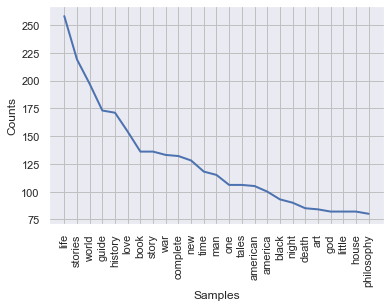

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [66]:
# задаю стиль графика
sns.set() 
freq = nltk.FreqDist(words_ns)
freq.plot(25)

Теперь я хочу произвести теже операции, но на датафрейме, чтобы получить дополнительные признаки. Это также пример на лямбда-функцию, в том числе совместно с генератором.

In [67]:
db_copy['title'] = db_copy['title'].apply(lambda x: tokenizer.tokenize(x)) 
db_copy['title'] = db_copy['title'].apply(lambda x: " ".join(x for x in x if x not in sw)) 
db_copy['title'] = db_copy['title'].str.lower()
db_copy.head(3) 

,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title
0,harry potter half blood prince,4.570,eng,652,2095690,27591,2000,3,1,1,39
1,harry potter order phoenix,4.490,eng,870,2153167,29221,2000,3,1,1,42
2,harry potter chamber secrets,4.420,eng,352,6333,244,2000,4,0,1,40


In [68]:
# функция для оценки эмоций
def senti(data): 
    return TextBlob(data).sentiment

# эмоциональность названия книги
db_copy['polarity'] = db_copy['title'].apply(lambda x: TextBlob(x).sentiment.polarity) 

In [69]:
# субъективность названия книги
db_copy['subjectivity'] = db_copy['title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
db_copy.head(3)

,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity
0,harry potter half blood prince,4.570,eng,652,2095690,27591,2000,3,1,1,39,-0.167,0.167
1,harry potter order phoenix,4.490,eng,870,2153167,29221,2000,3,1,1,42,0.000,0.000
2,harry potter chamber secrets,4.420,eng,352,6333,244,2000,4,0,1,40,0.000,0.000


Две оценки (-0.5, 0.875) означают следующее. Первая оценка - это негативный/позитивный заголовок (от -1 до 1, ближе к 1 позитивный, ближе к -1 негативный, 0 нейтральный). Вторая оценка - это объективный/субъективный заголовок (от 0 до 1, ближе к 1 субъективный).

Я получил три новых признака: длина названия, эмоциональная окраска, субъективность. Теперь применю статистический анализ. У меня только количественные признаки, установить я хочу корреляцию. Распределение **average_rating** не является нормальным. Поэтому применю корреляцию Спирмена. 

*Корреляция Спирмена*

*Когда применяется*

Если не выполняются условия для корреляции Пирсона.

*Условия применения теста*

*Альтернативы, если условия не выполняются*

1) гамма Гудмана и Краскелла; 
2) тау Кендела; 
3) d Сомерса.

*Формула*


*Интерпретация*

Нулевая гипотеза: нет связи между двумя переменными, то есть r = 0 в генеральной совокупности. 

Чем ближе к 1, тем сильнее связь.

*Особенности*

In [70]:
# корреляция один против всех по Спирмену

pg.pairwise_corr(db_copy, columns=[['average_rating'], ['len_title', 'polarity', 'subjectivity']], 
                method='spearman', padjust='bonf') 

,X,Y,method,alternative,n,r,CI95%,p-unc,p-corr,p-adjust,power
0,average_rating,len_title,spearman,two-sided,10838,0.163,"[0.14, 0.18]",0.000,0.000,bonf,1.000
1,average_rating,polarity,spearman,two-sided,10838,0.034,"[0.01, 0.05]",0.000,0.001,bonf,0.938
2,average_rating,subjectivity,spearman,two-sided,10838,0.035,"[0.02, 0.05]",0.000,0.001,bonf,0.953


Видно, что нет значимой корреляции ни с одним признаком. Создам облако слов для книг с положительными и отрицательными оценками.

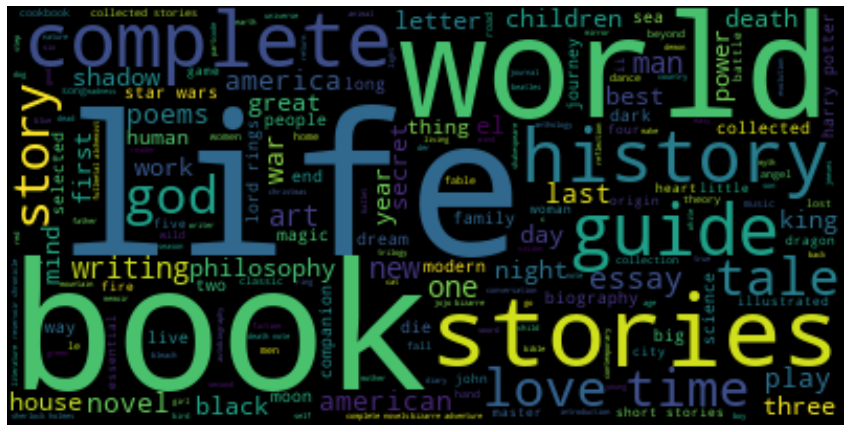

In [71]:
db_copy['rating'] = db_copy['average_rating'].apply(lambda rating: 'positive' if rating >=4 else 'negative')
positive = db_copy[db_copy['rating'] == 'positive']
negative = db_copy[db_copy['rating'] == 'negative']
pos = " ".join(x for x in positive['title'])
wordcloud1 = WordCloud(stopwords=sw).generate(pos) 
fig, ax = plt.subplots(figsize=(15, 10))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_pos.png')
plt.show()

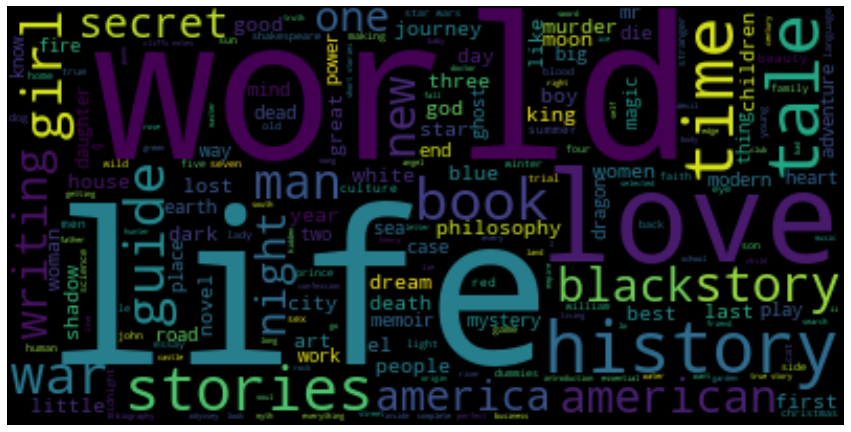

In [72]:
neg = " ".join(x for x in negative['title'])
wordcloud2 = WordCloud(stopwords=sw).generate(neg) 
fig, ax = plt.subplots(figsize=(15, 10))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_nega.png')
plt.show()

# Сохранение данных

In [73]:
db_copy = db_copy.drop('rating', axis=1)
db_copy.to_csv('gd_augmentation.csv', index=False) 

# Приложение 1

**Рекомендуемая литература:**

1) В. Гмурман Теория вероятностей и математическая статистика
2) Сара Бослаф Статистика для всех
3) П. Брюс Практическая статистика для специалистов Data Science
4) [Engineering statistics handbook](https://www.itl.nist.gov/div898/handbook/eda/eda.htm) (по тексту упоминается как учебник для инженеров)
5) Дэвидсон, Мак-Кинон Теория и методы эконометрики
6) Основы статистического обучения Тревор Хасти, Роберт Тибширани, Джером Фридман
7) Обработка естественного языка (Тушен Ганегедара)
8) С. Рашка, В. Мирджалили Python и машинное обучение (по тексту - учебник Машинное обучение)

**Полезные ссылки:**

1) документация по библиотеке [Pingoiun](https://pingouin-stats.org/) (также содержит описания статистических концепций, реализованных в составе библиотеки)
2) хорошее описание статистических процедур [PYTHON FOR DATA SCIENCE](https://www.pythonfordatascience.org/)
3) руководство по применению регулярных выражений [здесь](https://developers.google.com/edu/python/regular-expressions);
4) еще одно руководство по регулярным выражениям от проекта [Dataquest](https://www.dataquest.io/blog/regular-expressions-data-scientists/)
5) и еще немного про регулярные выражения от [Towards Data Science](https://towardsdatascience.com/easiest-way-to-remember-regular-expressions-regex-178ba518bebd)
6) математическая энциклопедия от проекта [Wolfram](https://mathworld.wolfram.com/)

**Ссылки на мои ресурсы:**

1) Twitter https://twitter.com/runaz_there
2) GitHub https://github.com/Ruslan-Nazarov
3) AI for everyone (Medium) https://medium.com/ai-for-everyone
4) LinkedIn https://www.linkedin.com/in/ruslan-nazarov-223003198/
5) email runaz2007@gmail.com OR runaz@protonmail.com

*В будущих редакциях методички*

1) будет дано более простое описание примененных тестов, а также приведены дополнительные тесты;
2) будет расширен анализ временных рядов.

# Приложение 2 Как выбрать подходящий тест

Как я указывал выше, тесты могут быть разделены на параметрические и непараметрические. К непараметрическим относятся также тесты с перестановкой (пермутацией). При этом надо различать пермутацию и бутстрап. Пермутация - это выборка без возвращения. Бутстрап - выборка с возвращением. Бутстрап применяют при наличии сильных выбросов и для определения надежности оценки, то есть для доверитальных интервалов.

Непараметрические тесты считаются менее надежными, чем параметрические, за исключением тестов с перестановкой.

Параметрические тесты требуют соблюдения следующих условий:

1) независимость выборок; 
2) нормальное распределение в генеральной совокупности; 
3) равенство дисперсий в выборках.

В том случае, если данные не соответсвуют нормальному распределению, можно выполнить следующее:

1) преобразовать данные таким образом, чтобы они соответствовали нормальному распределению (например, воспользоваться преобразованием Бокса-Кокса. На практике значение лямбда в этом преобразовании выбирается между чуть меньше нуля до чуть более 1. При этом степень кривизны, порождаемой преобразованием, растет при удалении лямбда от 1 в любую сторону);
2) применить непараметрические тесты;
3) положиться на центральную предельную теорему, если выборка значительная, то есть принять, что данные все-таки нормально распределены (другими словами - проигнорировать результаты теста).

Приведенное ниже описание выбора тестов сделано на основании данных, взятых [отсюда](https://pingouin-stats.org/guidelines.html#correlation). 


**Выбор параметрического теста**

*Есть ли выбросы и(или) отсутствует нормальное распределение?*

Если нет выбросов и распределение нормальное, то применяю корреляцию по Пирсону. 

Если есть выбросы и(или) распределение не нормальное, то применяю корреляцию Спирмена. При этом, если univariate outliers, то применяю biweight midcorrelation или percentage bend correlation (эти методы указываются при вызове corr(method=”__”) из библиотеки pingouin).

Если же bivariate outliers, то применяю skipped correlation или Shepherd correlation.


**Выбор непараметрического теста**

*Сколько групп?*

*Если две, то надо решить группы парные или нет?*

Если не парные, то тест Манн-Уитни. Если же парные, то тест Вилкоксона.

*Если три и более группы, то надо решить, парные или нет?*

Если не парные, то тест Краскалла-Уоллса с постхок тестом.

*Если же парные, то надо решить, данные бинарные или нет?*

Если бинарные, то тест Кохрана. Если нет, то Фридмана.

**Выбор теста ANOVA**

*Если выборки независимы, то надо ответить на вопрос, дисперсии равны?*

Если да, то классическая ANOVA, апостериорный тест - тест Tukey-HSD. Если нет, то Welch ANOVA, апостериорный - тест Games-Howell.

Если выборки зависимые, то применяю repeated measure ANOVA, парный t-test.

# Приложение 3 Некоторые популярные тесты

## Тест Стьюдента

Один из самых широко применяемых тестов.

*Когда применяется?*

Проверка равенства средних значений двух выборок.


*Условия применения теста*

1) независимость выборок; 
2) нормальность распределения; 
3) равенство дисперсий

*Альтернативы, если условия не выполняются*

Непараметрические тесты, в том числе пермутация; тест Велча

*Формула*

См. подробнее [здесь](https://www.pythonfordatascience.org/independent-samples-t-test-python/)

*Интерпретация*

См. подробнее [здесь](https://www.pythonfordatascience.org/independent-samples-t-test-python/)


*Особенности*

См. подробнее [здесь](https://www.pythonfordatascience.org/independent-samples-t-test-python/)

Подробно в параграфе 12 гл. 19 Гмурмана.

## Хи-квадрат

*Когда применяется?*

Для определения связи между двумя и более категориальными переменными.

*Условия применения теста*

1) независимость выборок; 
2) нет значений меньше 1; 
3) не более чем в 20% ячеек значения меньше 5.

*Альтернативы, если условия не выполняются*

Точный тест Фишера

*Формула*

См. подробнее [здесь](https://www.pythonfordatascience.org/chi-square-test-of-independence-python/)


*Интерпретация*

Нулевая гипотеза: переменные независимы.
Получаем статистику, если она значима, то есть p-value < 0.05, то нулевую гипотезу отвергаем.


*Особенности*

Хи-квадрат определяет только наличие или отсутствие зависимости между выборками. 
Силу корреляции между группами определяют по фи, коэффициенту сопряжённости и V коэффициенту Крамера.

# Приложение 4 Заметки к планированию исследования

Заметки ниже взяты из [Creating an Analysis Plan. Atlanta, GA: Centers for Disease Control and Prevention
(CDC), 2013](https://www.cdc.gov/globalhealth/healthprotection/fetp/training_modules/9/creating-analysis-plan_pw_final_09242013.pdf)

Это план исследования для анализа данных в медицине. Однако значения для меня это иметь здесь не будет, так как для наших зада информация вполне подходящая. 

Управление данными:

1) Создать a data dictionary.
2) Создать рабочую копию датасета.
3) Очистить данные в рабочей копии.
4) Создать an analysis file.

План исследования включает в себя следующее:

1) Определить исследовательскую задачу, гипотезы.
2) Выбрать и оценить датасет.
3) Составить inclusion/exclusion criteria (например, исследоваться будут только дети или только взрослые)
4) Просмотреть данные, чтобы определить the variables, которые можно использовать в анализе.
5) Подобрать подходящие статистические методы и программы.
6) Создать table shells.

Примечания.

1. Выбор датасета предполагает решение нескольких задач. Датасет может быть создан самостоятельно (в приложении про Спотифай показан пример). Датасет может быть создан другим лицом. В этом последнем случае надо убедиться, что известны ответы на следующие вопросы:
1) кто собственник датасета;
2) как можно получить доступ к датасету;
3) требуется ли разрешение на использование датасета, какая лицензия применяется к датасету. Часто речь идет о лиценизи MIT или creative common;
4) в соответствии с какими принципами, какими методами, на основании каких источников был собран датасет. Надо учитывать, что датасет может: а) представлять всю генеральную совокупность (например, все книги на сайте Goodreads), б) быть выборкой (все книги на сайте - это только выборка для всех вообще книг), причем репрезентативной выборкой, в) быть выборкой, но не репрезентативной.  
5) какой формат данных используется (часто это csv или json), в какой программе их можно открыть, какими способами можно работать с помощью языка Python.
6) общии характеристики датасета: количество признаков, количество наблюдений и т.п.

Если датасет не соответствует целям исследования, то необходимо принять меры для получения таких недостающих данных. 

2. Определение the variables означает, что надо установить признаки, целевые признаки. При этом надо либо удалить ненужные признаки из данных, либо обогатить данные. 

Анализ данных разбивается на однофакторный, двухфакторный, многофакторный. Фактор - это признак.

Однофакторный анализ включает определение распределения, статистических характеристик выборки. Его часто называют дескриптивным анализом. Для непрерывных данных надо определить среднее, медиану, моду. Для дискретных надо определить, например, частоту распределения (гистограмму). Здесь могут быть описаны агрегированные данные.

Двухфакторный анализ предполагает изучение взаимодействия между двумя признаками. Здесь речь идет, например, о корреляции. Надо помнить, что результаты статистических тестов должны быть даны с доверительными интервалами. "Статистические тесты включают t-тесты для непрерывных данных, тесты хи-квадрат (χ²) для категорийных данных, ANOVA для оценки непрерывной переменной в категориях и коэффициент корреляции для оценки корреляции между двумя непрерывными переменными".

# Приложение 5 Временные ряды

Здесь рассмотрю некоторые техники работы с временными рядами. Так как те данные, которые были использованы в основной части методички, не содержат данных о времени, я создам из первоначального набора подходящие данные.

In [74]:
data1 = pd.read_csv(os.getcwd() + '\\books.csv', 
                    error_bad_lines=False, index_col='publication_date')
data1.index = pd.to_datetime(data1.index, errors='coerce')
data1 = data1.loc[ :, ['average_rating', 'ratings_count']]

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


In [75]:
data1.head(3)

,average_rating,ratings_count
publication_date,,
2006-09-16,4.570,2095690
2004-09-01,4.490,2153167
2003-11-01,4.420,6333


In [76]:
data1 = data1.loc[~data1.index.isin(['NaT'])]

In [77]:
data1 = data1.sort_index()

Больше про временные ряды можно найти в учебнике для инженеров [6.4.Introduction to Time Series Analysis](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm). Здесь я сделаю только несколько замечаний.

Анализ временных рядов исходит из следующего предположения: точки данных, взятые с учетом времени, могут иметь внутреннюю структуру, например автокорреляцию, тренд, сезонность, что необходимо учитывать. 

Поэтому временной ряд определяется как "последовательность значений переменной через равные промежутки времени". 

Как правило, предполагается, что временной ряд является стационарным. Учебник для инженеров дает слелующее определение: "Стационарный процесс обладает тем свойством, что среднее значение, дисперсия и структура автокорреляции не изменяются с течением времени. Стационарность может быть определена в точных математических терминах, но для нашей цели мы имеем в виду плоский ряд без тренда, постоянную дисперсию во времени, постоянную структуру автокорреляции во времени и отсутствие периодических колебаний (сезонности)" ([6.4.4.2.Stationarity](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc442.htm)). Если данные не являются стационарными, они также могут быть приведены к стационарным, как показано в той же главе. 

В рамках использования датафрейма можно использовать два основных инструмента:

1) resample, который "пересобирает" данные. Например, можно указать, что данные из таблицы, в которой индекс является датой, должны быть сгруппированы по годам;
2) использование окна для подсчета метрики, попадающей в это окно. Например, можно посчитать среднее значение для каждых 5 предыдущих строчек.

Часто рекомендуется использовать экспоненциальное сглаживание. При этом одинарное сглаживание является базовым подходом, двойное сглаживание выявляет тренды, а тройное экспоненциальное сглаживание выявляет сезонность.

Для моделирования временных рядов может быть использовано несколько подходов. Например, это может быть разложение на тренд, сезонность и остатки с помощью тройного экспоненциального сглаживания. Другие подходы - это авторегрессионные модели, скользящее среднее. В учебнике для инженеров предлагается подробное описание модели Box-Jenkins, которая объединяет авторегрессию и скользящее среднее. Пример анализа можно найти в [6.6.2.
Aerosol Particle Size](https://www.itl.nist.gov/div898/handbook/pmc/section6/pmc62.htm).

Ниже показаны несколько основных инструментов для анализа рядов. 

<AxesSubplot:xlabel='publication_date'>

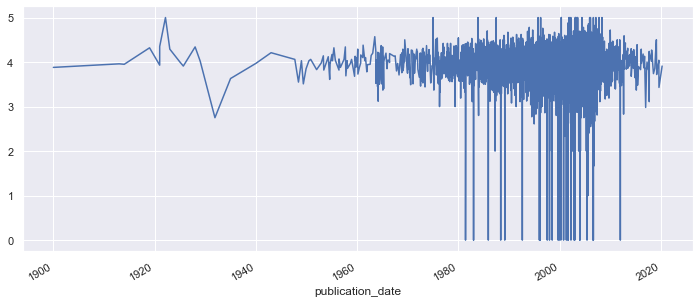

In [78]:
data1.average_rating.plot(figsize=[12, 5])

In [79]:
data1_resample = data1.average_rating.resample('Y').mean()

<AxesSubplot:xlabel='publication_date'>

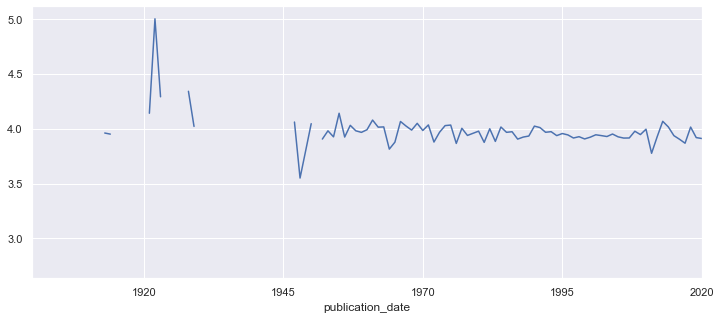

In [80]:
# простое сглаживание
data1_resample.plot(figsize=[12, 5])

<AxesSubplot:xlabel='publication_date'>

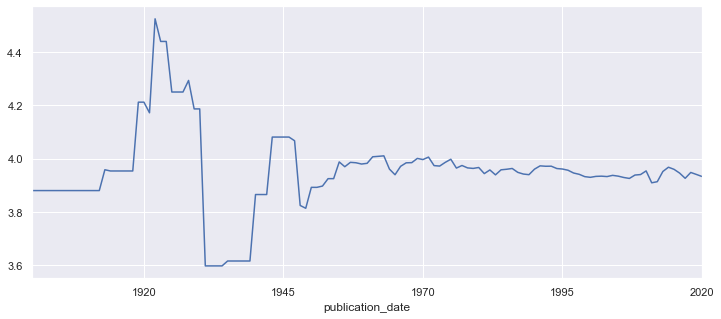

In [81]:
# экспоненциальное сглаживание
data1_resample.ewm(span=7).mean().plot(figsize=[12, 5])

In [82]:
data1_moving = data1.average_rating.rolling(5).mean()
data1_moving.head(10)

publication_date
1900-01-01     NaN
1913-01-01     NaN
1914-01-01     NaN
1919-01-01     NaN
1921-01-01   4.008
1921-01-01   4.102
1922-02-22   4.310
1923-01-01   4.378
1925-01-01   4.314
1925-09-01   4.310
Name: average_rating, dtype: float64

In [83]:
data1['average_rating_lag'] = data1['average_rating'].shift(1, fill_value=data1.average_rating.mean())
data1.head(3)

,average_rating,ratings_count,average_rating_lag
publication_date,,,
1900-01-01,3.880,332,3.934
1913-01-01,3.960,111,3.880
1914-01-01,3.950,87,3.960


Выше я создал новый столбец, в котором представлены значения average_rating со сдвигом на одну строку. Пропущенное значение (первое) заменено средним.

Здесь не показано, но также часто используется метод asfreq, который позволяет перестроить индекс по заданной частоте, например неделя, год.

# Приложение 6 Способы кодирования текста

Из книги Обработка естественного языка.

Задача - представление слов, то есть, грубо говоря, перевести слова в числа, но так, чтобы можно было, например, отличить, что слова "я" и "мы" ближе по смыслу, чем словам "кошка" и "вулкан".

Три популярных способов: WordNet, унитарное кодирование, частота слова-обратная частота документа (TF-IDF).

Пример унитарного кодирования можно найти на стр 80 Обработка языка: "если у нас есть словарь размера V, то каждое i-е слово wi
мы представим в  виде вектора длины V и вида [0, 0, 0, …, 0, 1, 0, …, 0, 0 , 0], где i-й элемент равен 1, а остальные элементы
равны нулю. В качестве примера рассмотрим такое предложение:
Боб и Мэри хорошие друзья.
Унитарное представление каждого слова может выглядеть следующим образом:
Боб: [1,0,0,0,0]
и: [0,1,0,0,0]
Мэри: [0,0,1,0,0]
хорошие: [0,0,0,1,0]
друзья: [0,0,0,0,1]".

TF-IDF можно понять через эти формулы стр 81:

TF(wi) = количество появлений слова wi  / общее количество слов;

IDF(wi) = log(общее количество документов / количество документов с wi);

TF-IDF(wi) = TF(wi)×IDF(wi).

Давайте выполним простое упражнение. Рассмотрим два документа:
doc1: Это документ про кошек. Кошки отличные домашние компаньоны.
doc2: Это документ про собак. Собаки очень преданные друзья.
Теперь сделаем вычисления:
TF-IDF(кошки, doc1) = (2/8) * log(2/1) = 0,075
TF-IDF(это, doc2) = (1/8) * log(2/2) = 0,0"

Более продвинутым считается метод Word2vec.